# Title

## Imports

In [142]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
import pandas_ta as ta  # pip install pandas-ta
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import tensorflow as tf
import numpy as np

## Dataset Preparation

### Sentiment Data

#### Loading Data

In [186]:
# First load all CSVs into DataFrames
dfs = {
    'roberta': pd.read_csv('bitcoin_sentiments_21_24_cleaned_benchmarked.csv'),
    'lstm': pd.read_csv('lstm_from_scratch_preds.csv'),
    'finbert': pd.read_csv('finetuned_finbert_preds_2.csv')
}

# Get the valid indices from FinBERT DataFrame
valid_indices = dfs['finbert']['index'].values

# Filter RoBERTa and benchmark DataFrames to keep only rows with indices present in FinBERT
#dfs['roberta'] = dfs['roberta'].iloc[valid_indices]

# Standardize date column names to lowercase
for df in dfs.values():
    date_col = next(col for col in df.columns if col.lower() == 'date')
    df.rename(columns={date_col: 'date'}, inplace=True)
    df['date'] = pd.to_datetime(df['date']).dt.date


#### Filling missing dates

In [163]:
# Define sentiment column names for each DataFrame
sentiment_columns = {
    'roberta': ['Sentiment_Category', 'Benchmark_Predictions'],
    'lstm': ['predicted_label'],
    'finbert': ['predicted_label']
}

# Fill missing dates for each DataFrame
for name, df in dfs.items():
    # Get min and max dates
    min_date = min(df['date'])
    max_date = max(df['date'])
    
    # Create complete date range
    all_dates = pd.DataFrame({
        'date': pd.date_range(min_date, max_date, freq='D').date
    })
    
    # Merge with original data and fill missing values with 3 (indicating no articles)
    dfs[name] = pd.merge(all_dates, df, on='date', how='left')
    for col in sentiment_columns[name]:
        dfs[name][col] = dfs[name][col].fillna(3)

#### Creating merged version for exploratory analysis later

In [187]:
exploratory_df = pd.DataFrame()
exploratory_df["date"] = dfs["roberta"]["date"]
exploratory_df["roberta_pred"] = dfs["roberta"]["Sentiment_Category"]
exploratory_df["benchmark_pred"] = dfs["roberta"]["Benchmark_Predictions"]
#exploratory_df["lstm_pred"] = dfs["lstm"]["predicted_label"]
exploratory_df["finbert_pred"] = dfs["finbert"]["predicted_label"]

#### Feature Engineering

In [167]:
def prepare_sentiment_data(df, sentiment_column, minimum_articles=5, start_date=None, end_date=None):
    """
    Prepare sentiment data with rolling averages and counts.
    
    Args:
        df (pd.DataFrame): DataFrame containing sentiment data
        sentiment_column (str): Name of the column containing sentiment categories (0/1/2)
        minimum_articles (int): Minimum number of articles required for filtering (default: 5)
        start_date (str): Start date in format 'YYYY-MM-DD' (default: None)
        end_date (str): End date in format 'YYYY-MM-DD' (default: None)
    """
    # Make a copy to avoid modifying the original
    df = df.copy()
    
    # Convert to datetime temporarily for filtering, then back to date
    df['date'] = pd.to_datetime(df['date']).dt.date
    if start_date:
        df = df[df['date'] >= pd.to_datetime(start_date).date()]
    if end_date:
        df = df[df['date'] <= pd.to_datetime(end_date).date()]
    
    # Add sentiment indicator columns
    df['is_zero'] = (df[sentiment_column] == 0).astype(int)
    df['is_one'] = (df[sentiment_column] == 1).astype(int)
    df['is_two'] = (df[sentiment_column] == 2).astype(int)  # Add indicator for neutral
    df['is_valid'] = (df[sentiment_column].isin([0, 1, 2])).astype(int)  # Consider 0, 1, 2 as valid

    # Sort and prepare for rolling calculations
    df = df.sort_values('date')
    df['date'] = pd.to_datetime(df['date'])  # Temporarily convert to datetime for rolling calculations
    df.set_index('date', inplace=True)
    
    # Define periods for rolling calculations
    periods = {
        'weekly': '7D',
        'monthly': '30D',
        'quarterly': '90D',
        'yearly': '365D'
    }
    
    # Calculate rolling values and counts for both sentiments
    for period_name, period_days in periods.items():
        # For positive sentiment (is_zero)
        df[f'rolling_{period_name}'] = (df['is_zero'].rolling(period_days).sum() / 
                                      df['is_valid'].rolling(period_days).sum() * 100)
        df[f'count_{period_name}'] = df['is_valid'].rolling(period_days).sum()
        
        # For negative sentiment (is_one)
        df[f'rolling_{period_name}_neg'] = (df['is_one'].rolling(period_days).sum() / 
                                          df['is_valid'].rolling(period_days).sum() * 100)
        df[f'count_{period_name}_neg'] = df['is_valid'].rolling(period_days).sum()
    
    # Reset index for groupby
    df.reset_index(inplace=True)
    
    # Calculate monthly counts and percentage change
    df['yearmonth'] = pd.to_datetime(df['date']).dt.to_period('M')
    # Count only valid articles (0, 1, 2) per month
    monthly_counts = df[df[sentiment_column].isin([0, 1, 2])].groupby('yearmonth').size().reset_index()
    monthly_counts.columns = ['yearmonth', 'count']
    
    # Create a mapping dictionary for current and previous month counts
    current_month_counts = dict(zip(monthly_counts['yearmonth'], monthly_counts['count']))
    prev_month_counts = dict(zip(monthly_counts['yearmonth'], monthly_counts['count'].shift(1)))
    
    # Map the counts to each row
    df['current_month_count'] = df['yearmonth'].map(current_month_counts)
    df['prev_month_count'] = df['yearmonth'].map(prev_month_counts)
    
    # Calculate percentage change
    df['prev_month_change'] = df.apply(
        lambda row: ((row['current_month_count'] - row['prev_month_count']) / row['prev_month_count'] * 100)
        if pd.notnull(row['prev_month_count']) and row['prev_month_count'] != 0
        else 0,
        axis=1
    )
    
    # Aggregate daily results
    daily_sentiment_df = (
        df.groupby('date', as_index=False)
        .agg(
            daily_sentiment=('is_zero', lambda x: x.mean() * 100),
            rolling_weekly=('rolling_weekly', 'last'),
            rolling_monthly=('rolling_monthly', 'last'),
            rolling_quarterly=('rolling_quarterly', 'last'),
            rolling_yearly=('rolling_yearly', 'last'),
            count_weekly=('count_weekly', 'last'),
            count_monthly=('count_monthly', 'last'),
            count_quarterly=('count_quarterly', 'last'),
            count_yearly=('count_yearly', 'last'),
            rolling_weekly_neg=('rolling_weekly_neg', 'last'),
            rolling_monthly_neg=('rolling_monthly_neg', 'last'),
            rolling_quarterly_neg=('rolling_quarterly_neg', 'last'),
            rolling_yearly_neg=('rolling_yearly_neg', 'last'),
            count_weekly_neg=('count_weekly_neg', 'last'),
            count_monthly_neg=('count_monthly_neg', 'last'),
            count_quarterly_neg=('count_quarterly_neg', 'last'),
            count_yearly_neg=('count_yearly_neg', 'last'),
            prev_month_change=('prev_month_change', 'first')
        )
    )
    
    #make monthly sentiment stationary by first differencing
    daily_sentiment_df['rolling_monthly_diff'] = daily_sentiment_df['rolling_monthly'].diff()
    
    # Adding total count columns (pos+neg+neutral)
    daily_sentiment_df["count_weekly_total"] = daily_sentiment_df["count_weekly"]
    daily_sentiment_df["count_monthly_total"] = daily_sentiment_df["count_monthly"]
    daily_sentiment_df["count_quarterly_total"] = daily_sentiment_df["count_quarterly"]
    daily_sentiment_df["count_yearly_total"] = daily_sentiment_df["count_yearly"]
    
    #add higher order terms to capture non-linear relationships
    #add squared rolling_monthly, rolling_monthly_neg and prev_month_change
    daily_sentiment_df['rolling_monthly_squared'] = daily_sentiment_df['rolling_monthly']**2
    daily_sentiment_df['rolling_monthly_neg_squared'] = daily_sentiment_df['rolling_monthly_neg']**2
    daily_sentiment_df['prev_month_change_squared'] = daily_sentiment_df['prev_month_change']**2

    #add interaction terms
    #rolling_monthly * prev_month_change
    daily_sentiment_df['rolling_monthly_prev_month_change'] = daily_sentiment_df['rolling_monthly'] * daily_sentiment_df['prev_month_change']
    #rolling_monthly_neg * prev_month_change
    daily_sentiment_df['rolling_monthly_neg_prev_month_change'] = daily_sentiment_df['rolling_monthly_neg'] * daily_sentiment_df['prev_month_change']
    #rolling counts * rolling_monthly
    daily_sentiment_df['count_weekly_rolling_monthly'] = daily_sentiment_df['count_weekly'] * daily_sentiment_df['rolling_monthly']
    daily_sentiment_df['count_monthly_rolling_monthly'] = daily_sentiment_df['count_monthly'] * daily_sentiment_df['rolling_monthly']
    daily_sentiment_df['count_quarterly_rolling_monthly'] = daily_sentiment_df['count_quarterly'] * daily_sentiment_df['rolling_monthly']
    daily_sentiment_df['count_yearly_rolling_monthly'] = daily_sentiment_df['count_yearly'] * daily_sentiment_df['rolling_monthly']
    #rolling counts * rolling_monthly_neg
    daily_sentiment_df['count_weekly_rolling_monthly_neg'] = daily_sentiment_df['count_weekly'] * daily_sentiment_df['rolling_monthly_neg']
    daily_sentiment_df['count_monthly_rolling_monthly_neg'] = daily_sentiment_df['count_monthly'] * daily_sentiment_df['rolling_monthly_neg']
    daily_sentiment_df['count_quarterly_rolling_monthly_neg'] = daily_sentiment_df['count_quarterly'] * daily_sentiment_df['rolling_monthly_neg']
    daily_sentiment_df['count_yearly_rolling_monthly_neg'] = daily_sentiment_df['count_yearly'] * daily_sentiment_df['rolling_monthly_neg']
    
    # Convert back to date
    daily_sentiment_df['date'] = pd.to_datetime(daily_sentiment_df['date']).dt.date
    
    # Filter based on minimum articles
    filtered_sentiment_df = daily_sentiment_df[
        (daily_sentiment_df['count_weekly'] > minimum_articles) &
        (daily_sentiment_df['count_monthly'] > minimum_articles) &
        (daily_sentiment_df['count_weekly_neg'] > minimum_articles) &
        (daily_sentiment_df['count_monthly_neg'] > minimum_articles)
    ]
    
    return filtered_sentiment_df

In [168]:
# Create dictionary of sentiment DataFrames with descriptive names
sentiment_dfs = {
    'roberta': prepare_sentiment_data(
        dfs['roberta'],
        'Sentiment_Category',
        10,
        #start_date='2022-01-19',
        #end_date='2023-12-10'
    ),
    'benchmark': prepare_sentiment_data(
        dfs['roberta'],
        'Benchmark_Predictions',
        10,
        #start_date='2022-01-19',
        #end_date='2023-12-10'
    ),
    'finbert': prepare_sentiment_data(
        dfs['finbert'],
        'predicted_label',
        10,
        #start_date='2022-01-19',
        #end_date='2023-12-10'
    )
}

### Bitcoin Price Data

In [169]:
#Create bitcoin dataframe
bitcoin_prices = pd.read_csv('bitcoin_data.csv')

#convert the date column to date instead of datetime
bitcoin_prices['Date'] = pd.to_datetime(bitcoin_prices['Date']).dt.date

# Define intervals for returns (in days)
intervals = {
    'D1': 1,
    'D2': 2,
    'D3': 3,
    'W1': 7,
    'M1': 30,
    'Q1': 90,
    'Y1': 365
}

# Add future return columns
for name, days in intervals.items():
    bitcoin_prices[f'Return_{name}'] = bitcoin_prices['Price'].shift(-days) / bitcoin_prices['Price'] - 1

# Add historical return columns (excluding quarterly and yearly periods)
historical_intervals = {k: v for k, v in intervals.items() if v <= 30}  # Only include up to monthly returns
for name, days in historical_intervals.items():
    bitcoin_prices[f'Return_{name}_H'] = bitcoin_prices['Price'].shift(days) / bitcoin_prices['Price'] - 1

# Add technical indicators using pandas-ta
# Exponential Moving Average (EMA)
bitcoin_prices['EMA'] = ta.ema(bitcoin_prices['Price'], length=20)

# Relative Strength Index (RSI)
bitcoin_prices['RSI'] = ta.rsi(bitcoin_prices['Price'], length=14)

# Moving Average Convergence Divergence (MACD)
macd = ta.macd(bitcoin_prices['Price'])
bitcoin_prices['MACD'] = macd['MACD_12_26_9']
bitcoin_prices['MACD_signal'] = macd['MACDs_12_26_9']

# Ensure no NaN values exist in the data due to indicator calculations
bitcoin_prices = bitcoin_prices.dropna()

# Change Date column to lowercase 
bitcoin_prices.rename(columns={'Date': 'date'}, inplace=True)

# Display the dataframe
bitcoin_prices.head()

,date,Price,Return_D1,Return_D2,Return_D3,Return_W1,Return_M1,Return_Q1,Return_Y1,Return_D1_H,Return_D2_H,Return_D3_H,Return_W1_H,Return_M1_H,EMA,RSI,MACD,MACD_signal
33,2021-06-13,38894.5563,0.032595,0.032874,-0.008666,-0.082619,-0.163255,0.163482,-0.475262,-0.083287,-0.039928,-0.056036,-0.091501,0.286367,37802.348249,49.855465,-1851.463627,-2682.102706
34,2021-06-14,40162.3201,0.000271,-0.039959,-0.060761,-0.211710,-0.178239,0.133166,-0.521778,-0.031566,-0.112223,-0.070233,-0.153023,0.192302,38027.107473,53.043494,-1446.224772,-2434.927119
35,2021-06-15,40173.1950,-0.040219,-0.061015,-0.115817,-0.193384,-0.208846,0.122584,-0.487239,-0.000271,-0.031828,-0.112464,-0.166005,0.135200,38231.496761,53.071056,-1111.381236,-2170.217942
36,2021-06-16,38557.4792,-0.021668,-0.078766,-0.075243,-0.130331,-0.180540,0.219995,-0.469924,0.041904,0.041622,0.008742,-0.037095,0.118965,38262.542708,48.514745,-965.263130,-1929.226980
37,2021-06-17,37722.0202,-0.058363,-0.054762,-0.054103,-0.079623,-0.161208,0.275783,-0.447725,0.022148,0.064980,0.064692,-0.026695,0.145115,38211.064373,46.301179,-906.429285,-1724.667441


### Merging Data

In [208]:
# Merge each sentiment DataFrame with bitcoin prices
merged_dfs = {}
for name, df in sentiment_dfs.items():
    merged_dfs[name] = pd.merge(df, bitcoin_prices, on='date', how='inner')
    
#removing Nan's 
# Assuming your dictionary of DataFrames is named 'df_dict'
for key, df in merged_dfs.items():
    # Count the number of NaN values in the DataFrame
    nan_count = df.isna().sum().sum()
    
    # Print the number of NaN values for each DataFrame
    print(f"DataFrame '{key}' has {nan_count} NaN values.")
    
    # Remove rows with NaN values
    merged_dfs[key] = df.dropna()


DataFrame 'roberta' has 1 NaN values.
DataFrame 'benchmark' has 1 NaN values.
DataFrame 'finbert' has 1 NaN values.


## Explorative Analysis

### Number of Articles per Month

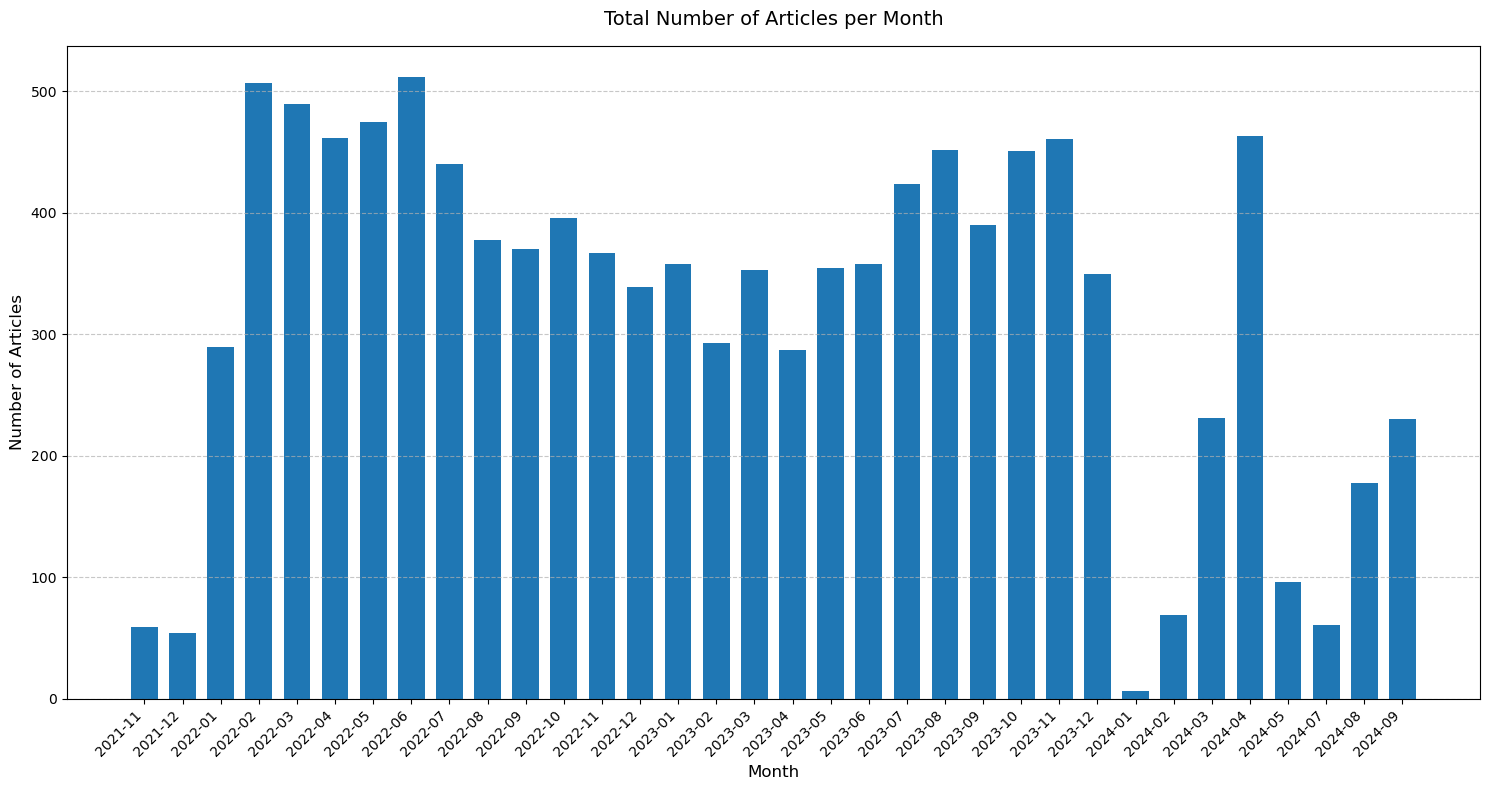

In [188]:
# Create monthly counts
monthly_df = exploratory_df.copy()
monthly_df['month'] = pd.to_datetime(monthly_df['date']).dt.strftime('%Y-%m')
monthly_counts = monthly_df.groupby('month').size()

# Create figure
plt.figure(figsize=(15, 8))

# Create bar plot
plt.bar(range(len(monthly_counts)), monthly_counts.values, width=0.7)

# Customize the plot
plt.title('Total Number of Articles per Month', fontsize=14, pad=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)

# Set x-axis ticks
plt.xticks(range(len(monthly_counts)), monthly_counts.index, rotation=45, ha='right')

# Add grid
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Number of Positive/Negative/Neutral Articles

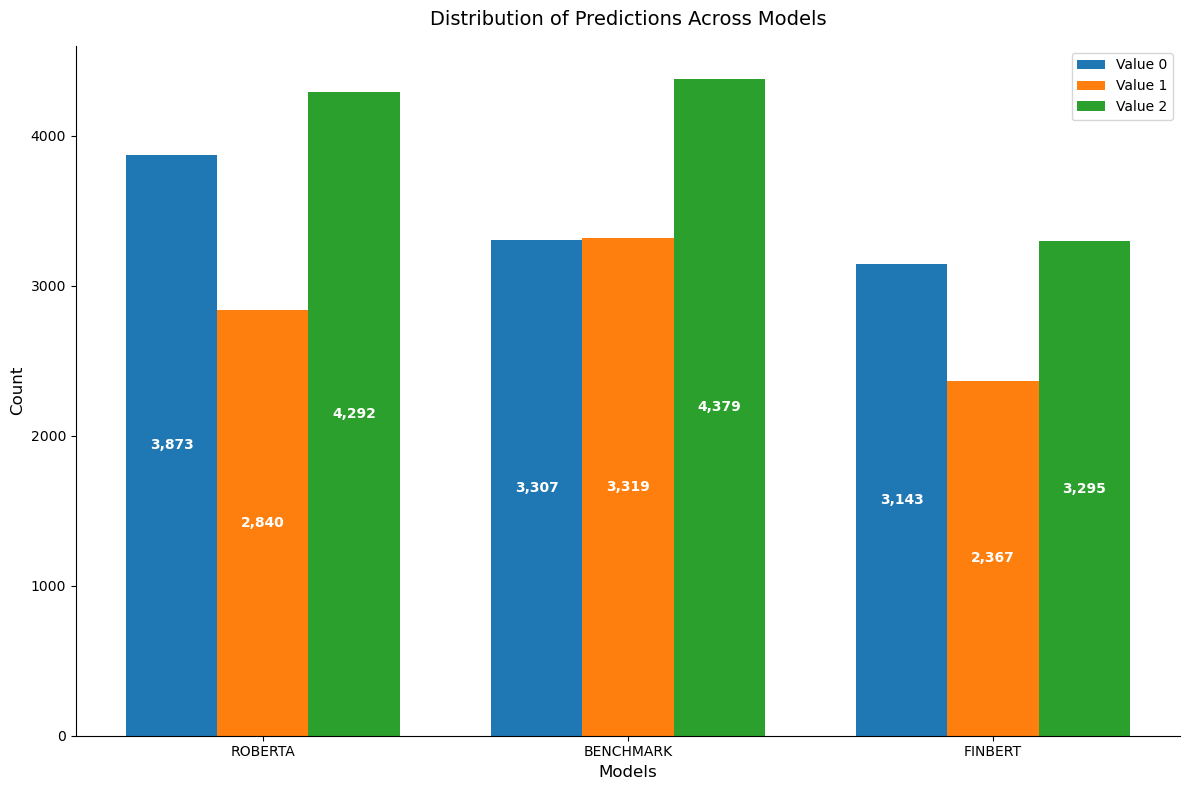

In [189]:
# Create figure with appropriate size
plt.figure(figsize=(12, 8))

# Get columns excluding 'date'
pred_columns = [col for col in exploratory_df.columns if col != 'date']

# Calculate value counts for each prediction column
counts_data = {col: exploratory_df[col].value_counts() for col in pred_columns}

# Create bar positions
x = np.arange(len(pred_columns))
width = 0.25

# Plot bars for each value (0, 1, 2)
for i, value in enumerate([0, 1, 2]):
    counts = [counts_data[col].get(value, 0) for col in pred_columns]
    bars = plt.bar(x + (i-1)*width, counts, width, label=f'Value {value}')
    
    # Add value labels inside the bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height/2.,
                f'{int(height):,}',
                ha='center', va='center', color='white', fontweight='bold')

# Customize the plot
plt.title('Distribution of Predictions Across Models', fontsize=14, pad=15)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(x, [col.replace('_pred', '').upper() for col in pred_columns])
plt.legend()

# Remove spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Number of Positive/Negative/Neutral Articles per month

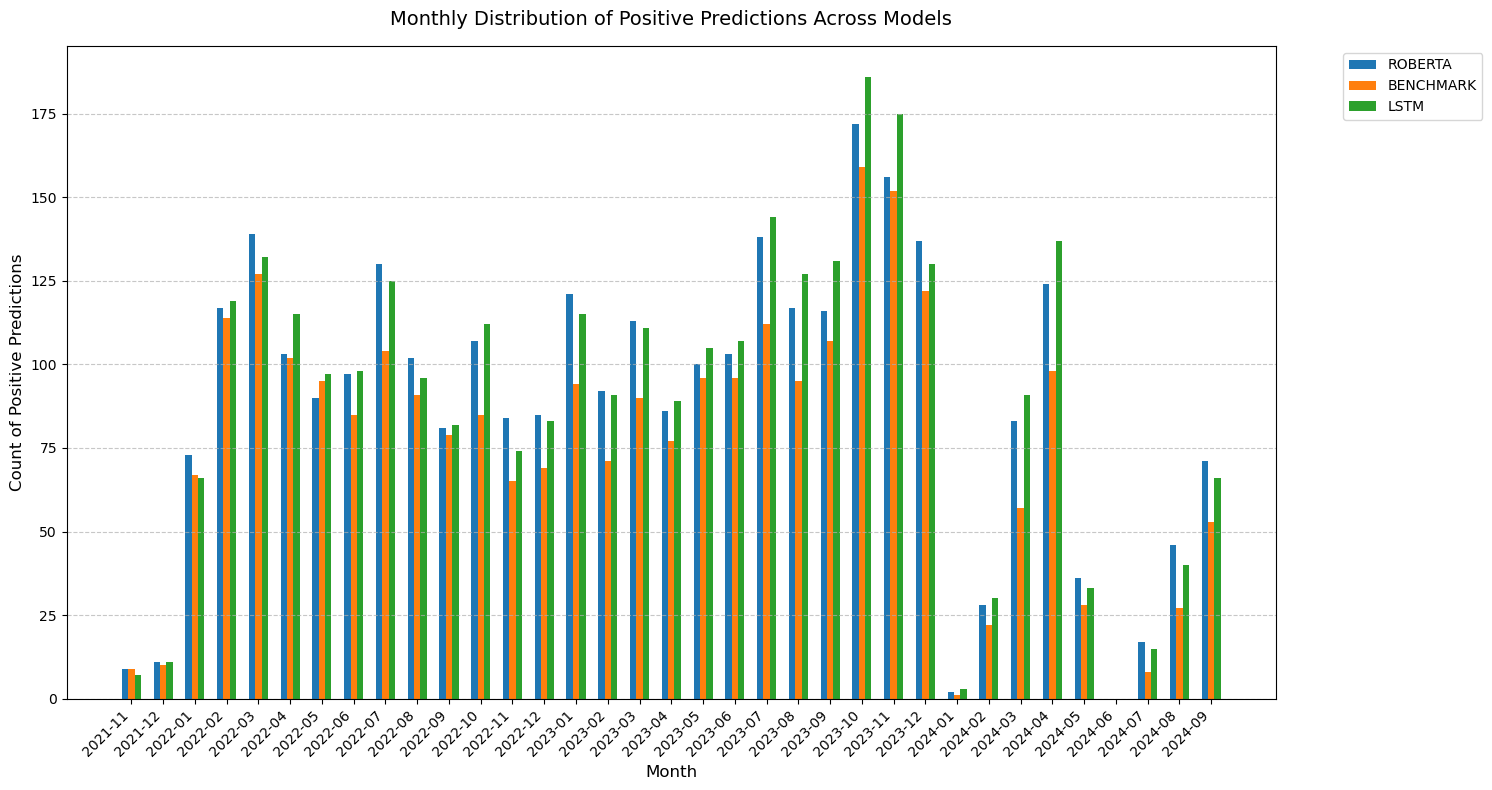

In [279]:
# Create a copy and extract month from date
monthly_df = exploratory_df.copy()
monthly_df['month'] = pd.to_datetime(monthly_df['date']).dt.strftime('%Y-%m')

# Get columns excluding 'date' and 'month'
pred_columns = [col for col in monthly_df.columns if col not in ['date', 'month']]

# Calculate monthly counts of positive predictions (0) for each model
monthly_counts = {}
for col in pred_columns:
    monthly_counts[col] = monthly_df[monthly_df[col] == 0].groupby('month').size()

# Create figure with appropriate size
plt.figure(figsize=(15, 8))

# Create bar positions
months = sorted(monthly_df['month'].unique())
x = np.arange(len(months))
width = 0.2  # Adjust based on number of models

# Plot bars for each model
for i, (model, counts) in enumerate(monthly_counts.items()):
    # Ensure counts exist for all months (fill with 0 if missing)
    model_counts = [counts.get(month, 0) for month in months]
    plt.bar(x + (i-len(pred_columns)/2+0.5)*width, model_counts, width, 
            label=model.replace('_pred', '').upper())

# Customize the plot
plt.title('Monthly Distribution of Positive Predictions Across Models', fontsize=14, pad=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Count of Positive Predictions', fontsize=12)

# Set x-axis ticks
plt.xticks(x, months, rotation=45, ha='right')

# Add legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

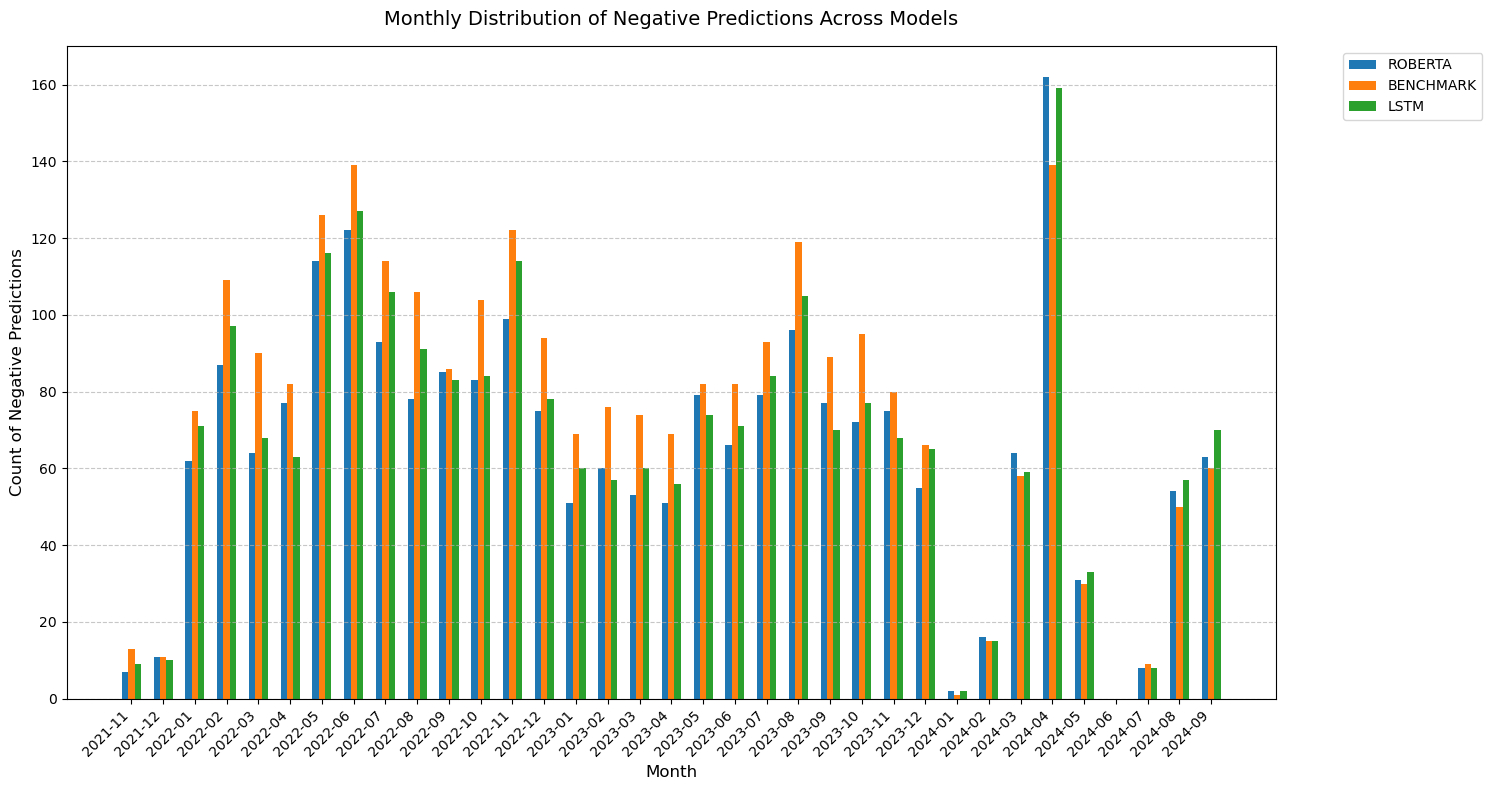

In [280]:
# Create a copy and extract month from date
monthly_df = exploratory_df.copy()
monthly_df['month'] = pd.to_datetime(monthly_df['date']).dt.strftime('%Y-%m')

# Get columns excluding 'date' and 'month'
pred_columns = [col for col in monthly_df.columns if col not in ['date', 'month']]

# Calculate monthly counts of negative predictions (1) for each model
monthly_counts = {}
for col in pred_columns:
    monthly_counts[col] = monthly_df[monthly_df[col] == 1].groupby('month').size()

# Create figure with appropriate size
plt.figure(figsize=(15, 8))

# Create bar positions
months = sorted(monthly_df['month'].unique())
x = np.arange(len(months))
width = 0.2  # Adjust based on number of models

# Plot bars for each model
for i, (model, counts) in enumerate(monthly_counts.items()):
    # Ensure counts exist for all months (fill with 0 if missing)
    model_counts = [counts.get(month, 0) for month in months]
    plt.bar(x + (i-len(pred_columns)/2+0.5)*width, model_counts, width, 
            label=model.replace('_pred', '').upper())

# Customize the plot
plt.title('Monthly Distribution of Negative Predictions Across Models', fontsize=14, pad=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Count of Negative Predictions', fontsize=12)

# Set x-axis ticks
plt.xticks(x, months, rotation=45, ha='right')

# Add legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

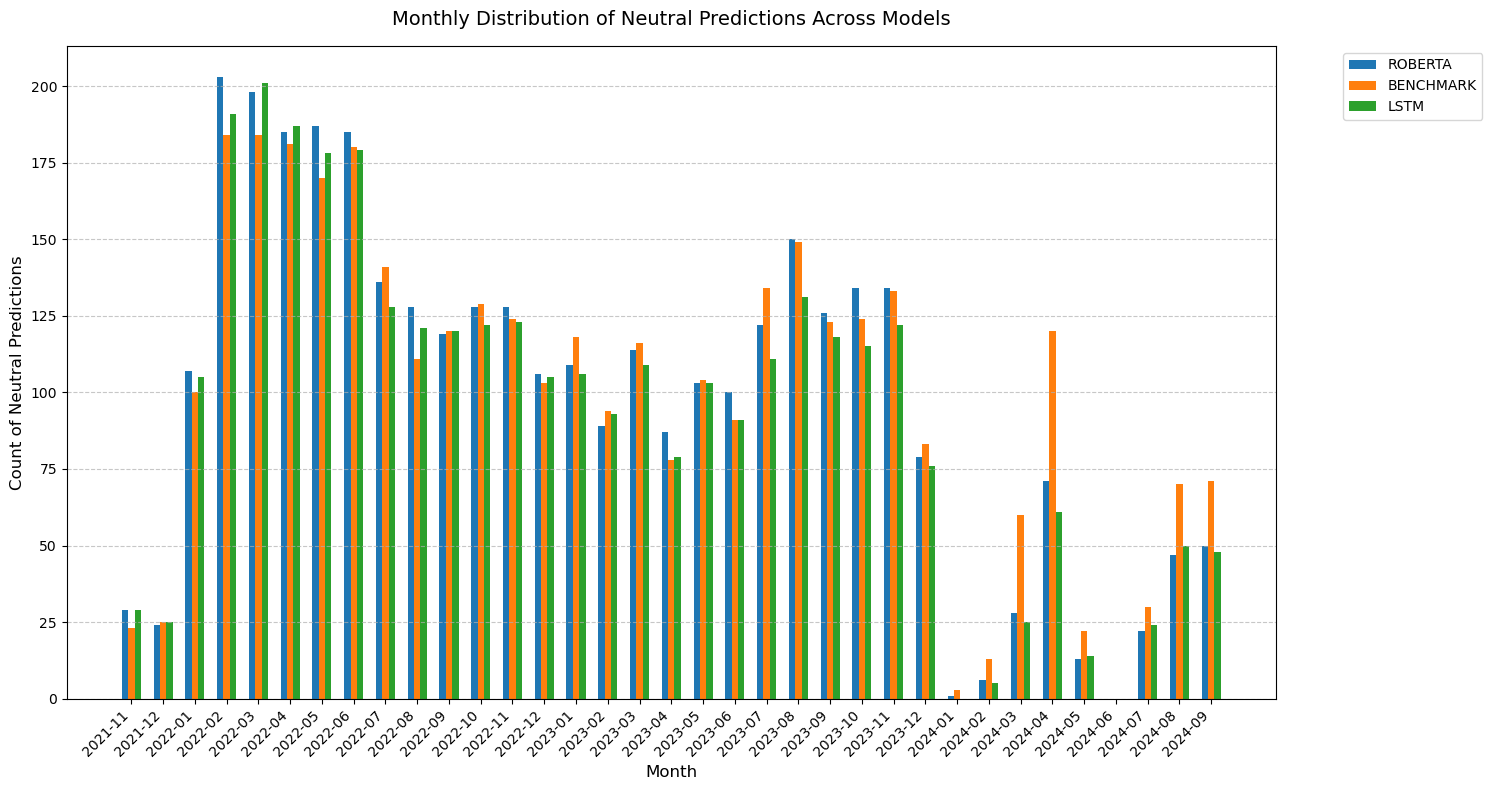

In [281]:
# Create a copy and extract month from date
monthly_df = exploratory_df.copy()
monthly_df['month'] = pd.to_datetime(monthly_df['date']).dt.strftime('%Y-%m')

# Get columns excluding 'date' and 'month'
pred_columns = [col for col in monthly_df.columns if col not in ['date', 'month']]

# Calculate monthly counts of neutral predictions (2) for each model
monthly_counts = {}
for col in pred_columns:
    monthly_counts[col] = monthly_df[monthly_df[col] == 2].groupby('month').size()

# Create figure with appropriate size
plt.figure(figsize=(15, 8))

# Create bar positions
months = sorted(monthly_df['month'].unique())
x = np.arange(len(months))
width = 0.2  # Adjust based on number of models

# Plot bars for each model
for i, (model, counts) in enumerate(monthly_counts.items()):
    # Ensure counts exist for all months (fill with 0 if missing)
    model_counts = [counts.get(month, 0) for month in months]
    plt.bar(x + (i-len(pred_columns)/2+0.5)*width, model_counts, width, 
            label=model.replace('_pred', '').upper())

# Customize the plot
plt.title('Monthly Distribution of Neutral Predictions Across Models', fontsize=14, pad=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Count of Neutral Predictions', fontsize=12)

# Set x-axis ticks
plt.xticks(x, months, rotation=45, ha='right')

# Add legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

### % Positive over Time

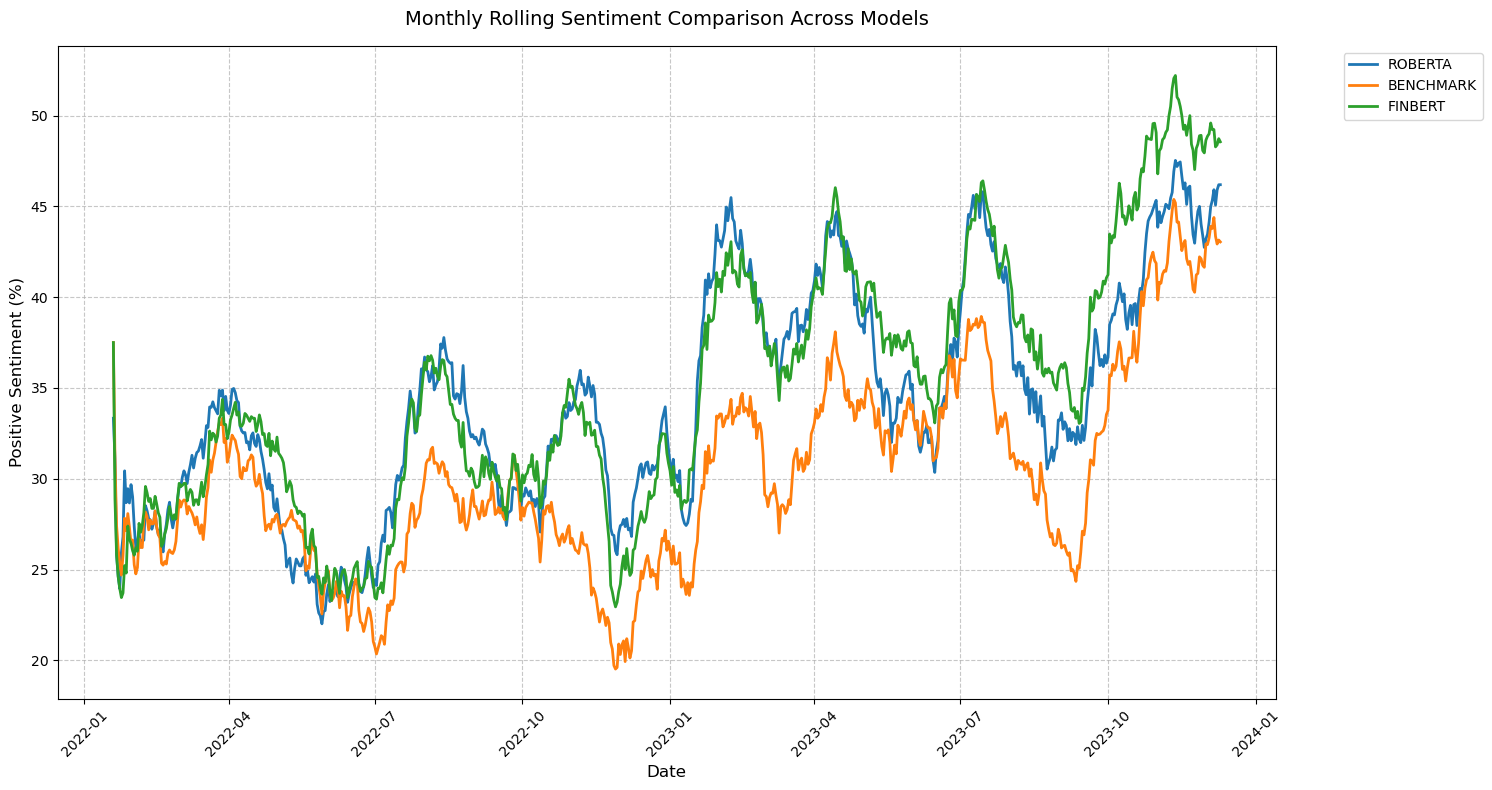

In [171]:
# Create figure with appropriate size
plt.figure(figsize=(15, 8))

# Plot monthly rolling sentiment for each model
for name, df in merged_dfs.items():
    plt.plot(df['date'], df['rolling_monthly'], label=name.upper(), linewidth=2)

# Customize the plot
plt.title('Monthly Rolling Sentiment Comparison Across Models', fontsize=14, pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Positive Sentiment (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

### % Negative over Time

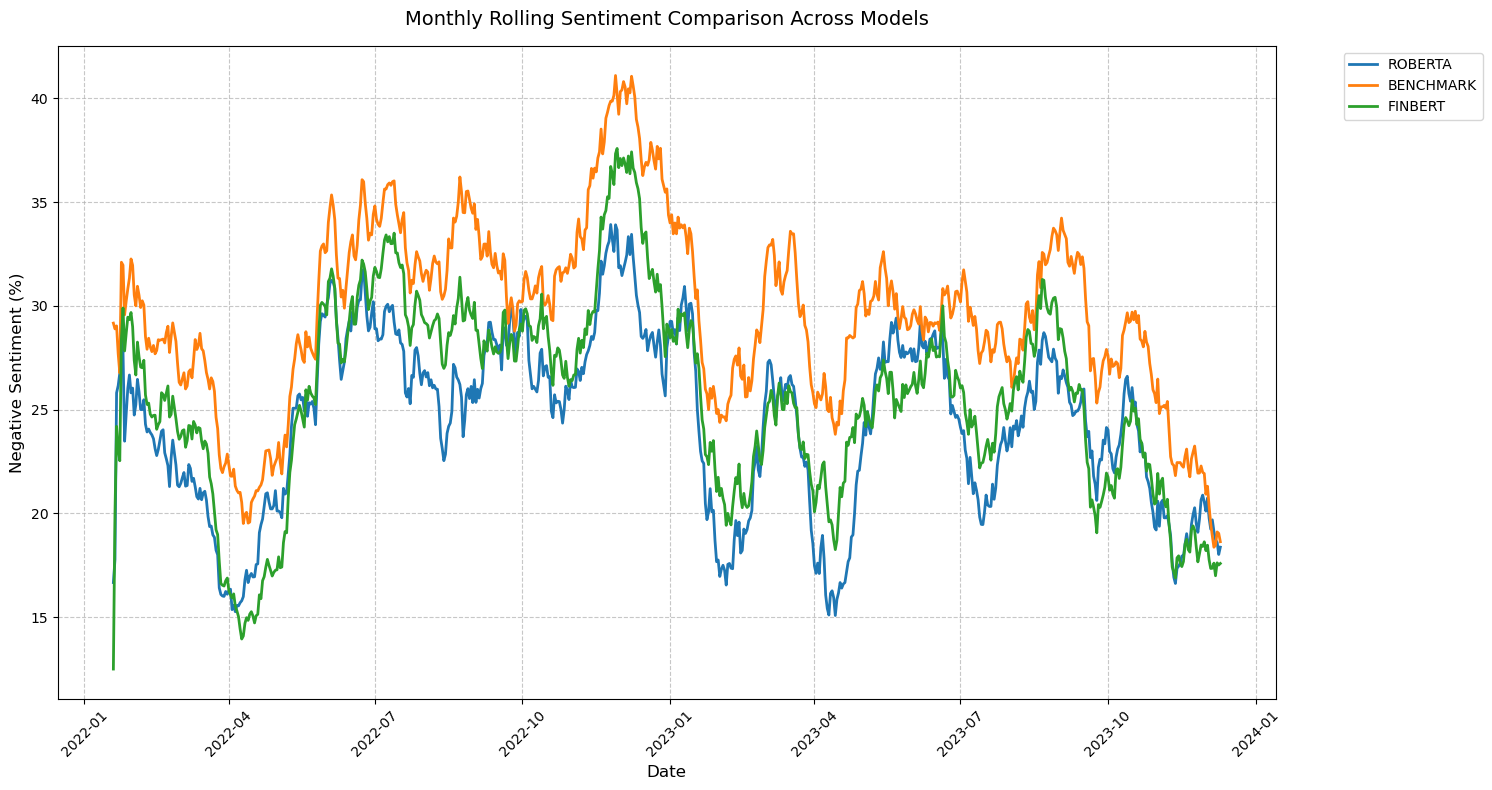

In [172]:
# Create figure with appropriate size
plt.figure(figsize=(15, 8))

# Plot monthly rolling sentiment for each model
for name, df in merged_dfs.items():
    plt.plot(df['date'], df['rolling_monthly_neg'], label=name.upper(), linewidth=2)

# Customize the plot
plt.title('Monthly Rolling Sentiment Comparison Across Models', fontsize=14, pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Negative Sentiment (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

### Rolling positive sentiment vs returns

### Exploring potential non-stationarity of sentiment and rolling article counts


Analyzing ROBERTA model:
Augmented Dickey-Fuller Test Results for roberta Monthly Positive Sentiment:
ADF Statistic: -8.1901
p-value: 0.0000
Critical values:
	1%: -3.4400
	5%: -2.8658
	10%: -2.5690




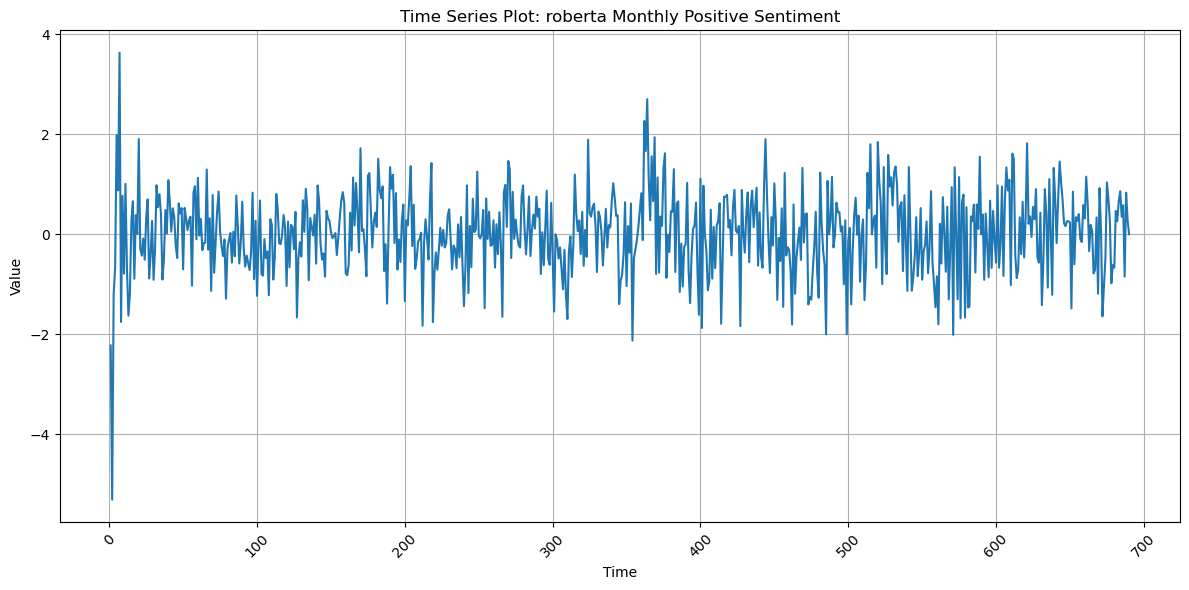

Augmented Dickey-Fuller Test Results for roberta Monthly Negative Sentiment:
ADF Statistic: -2.4219
p-value: 0.1357
Critical values:
	1%: -3.4399
	5%: -2.8658
	10%: -2.5690




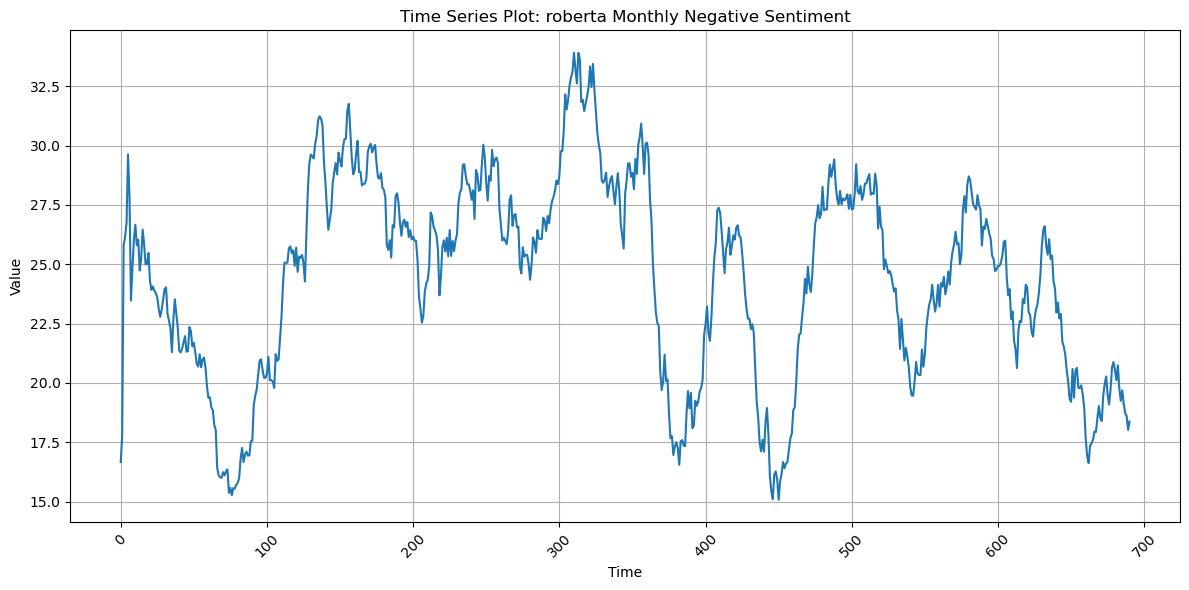

Augmented Dickey-Fuller Test Results for roberta Monthly Returns:
ADF Statistic: -3.5461
p-value: 0.0069
Critical values:
	1%: -3.4399
	5%: -2.8658
	10%: -2.5690




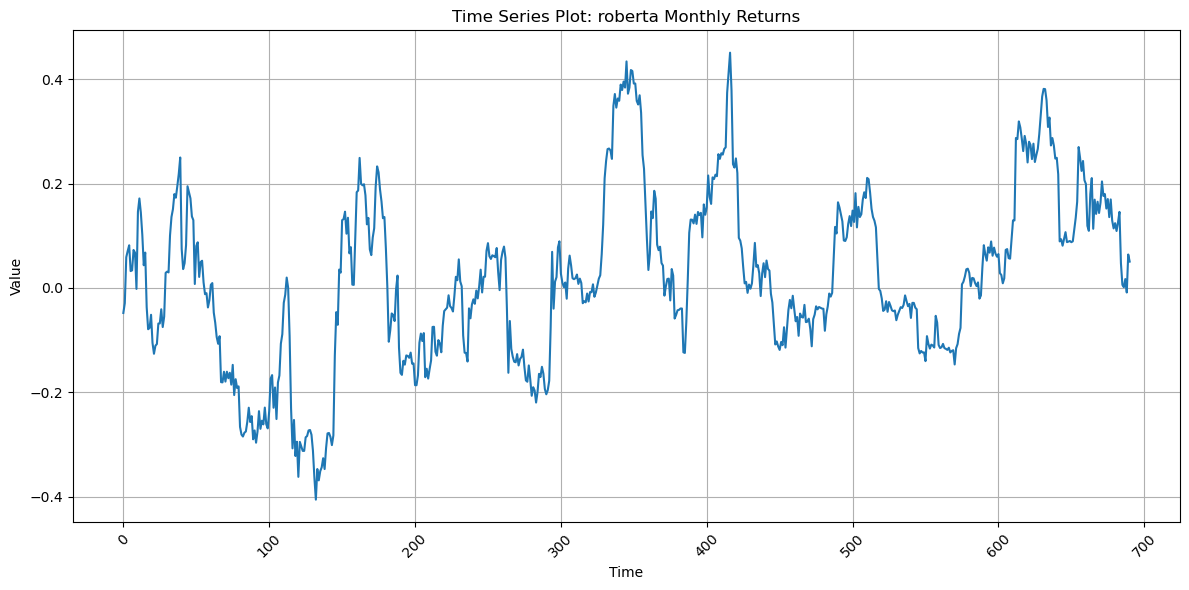

Augmented Dickey-Fuller Test Results for roberta Monthly Returns:
ADF Statistic: -2.4385
p-value: 0.1312
Critical values:
	1%: -3.4401
	5%: -2.8658
	10%: -2.5691




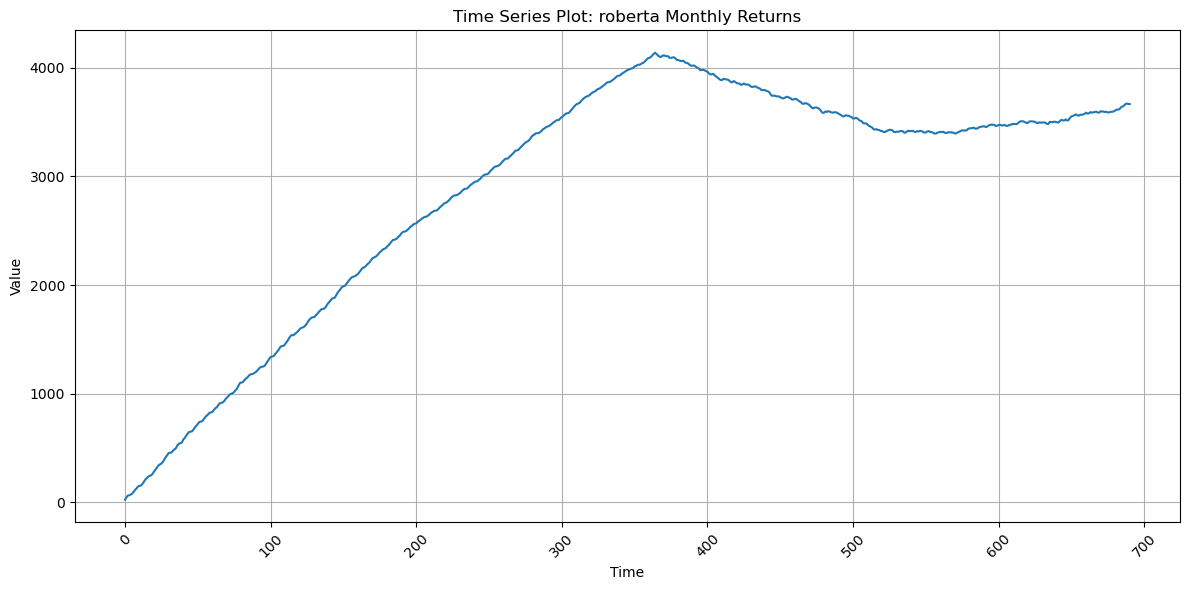


Analyzing BENCHMARK model:
Augmented Dickey-Fuller Test Results for benchmark Monthly Positive Sentiment:
ADF Statistic: -7.4786
p-value: 0.0000
Critical values:
	1%: -3.4400
	5%: -2.8658
	10%: -2.5690




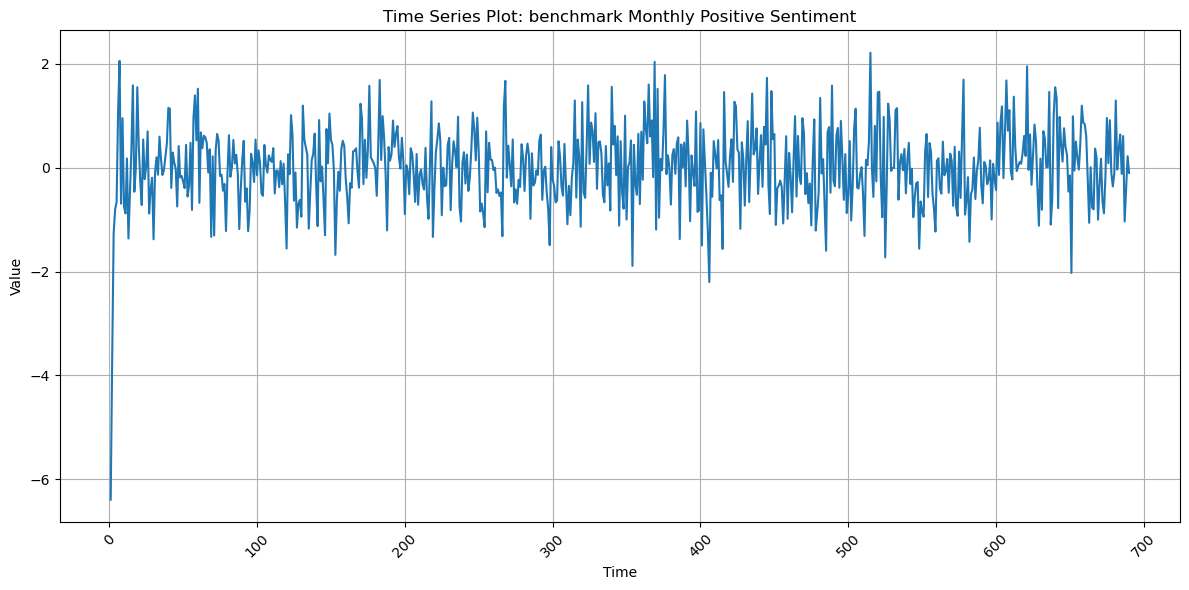

Augmented Dickey-Fuller Test Results for benchmark Monthly Negative Sentiment:
ADF Statistic: -2.7467
p-value: 0.0663
Critical values:
	1%: -3.4401
	5%: -2.8659
	10%: -2.5691




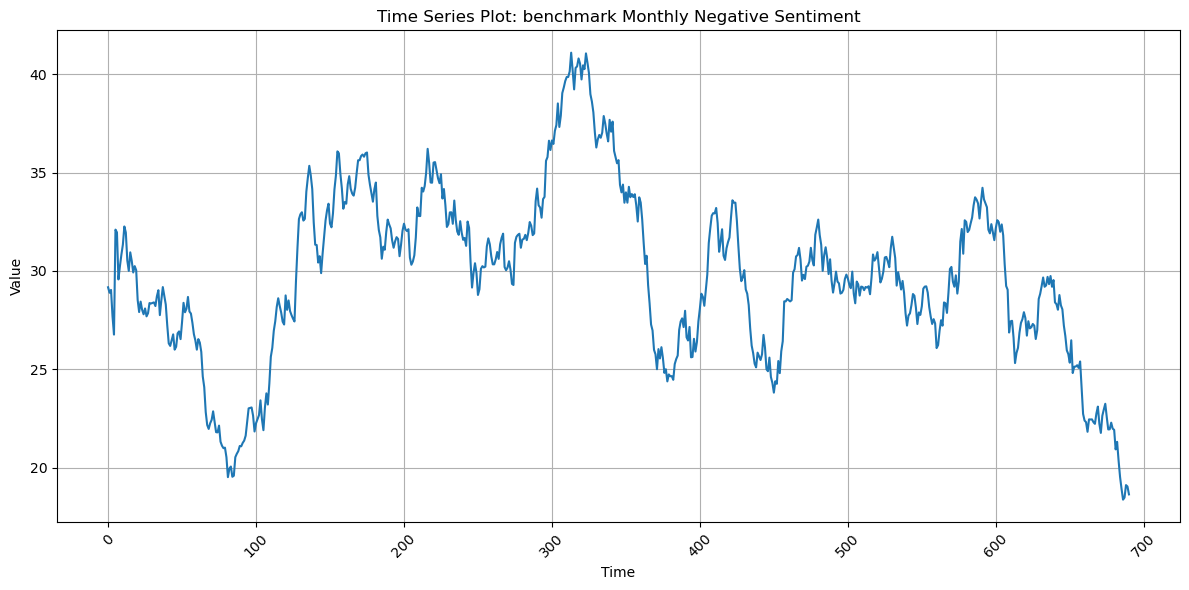

Augmented Dickey-Fuller Test Results for benchmark Monthly Returns:
ADF Statistic: -3.5461
p-value: 0.0069
Critical values:
	1%: -3.4399
	5%: -2.8658
	10%: -2.5690




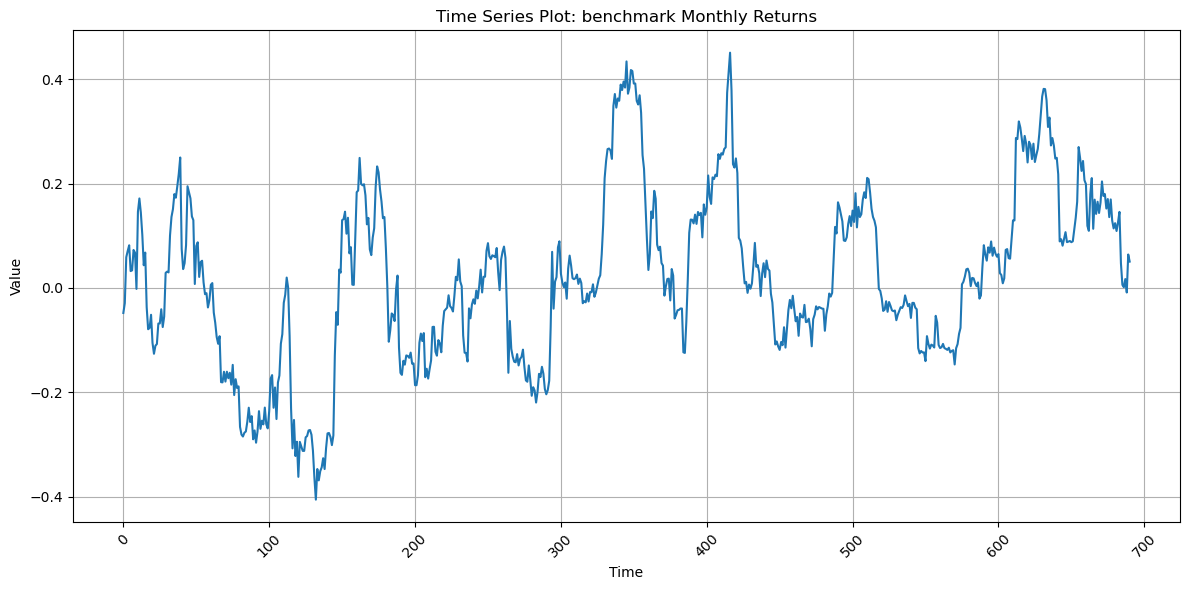

Augmented Dickey-Fuller Test Results for benchmark Monthly Returns:
ADF Statistic: -2.4385
p-value: 0.1312
Critical values:
	1%: -3.4401
	5%: -2.8658
	10%: -2.5691




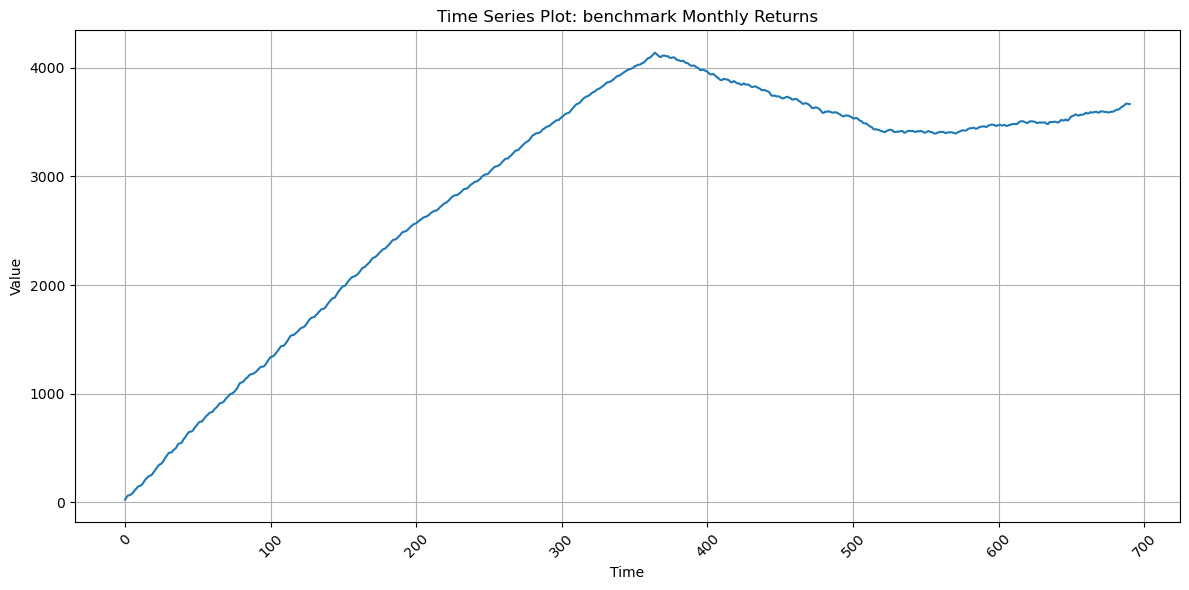


Analyzing FINBERT model:
Augmented Dickey-Fuller Test Results for finbert Monthly Positive Sentiment:
ADF Statistic: -6.8085
p-value: 0.0000
Critical values:
	1%: -3.4400
	5%: -2.8658
	10%: -2.5690




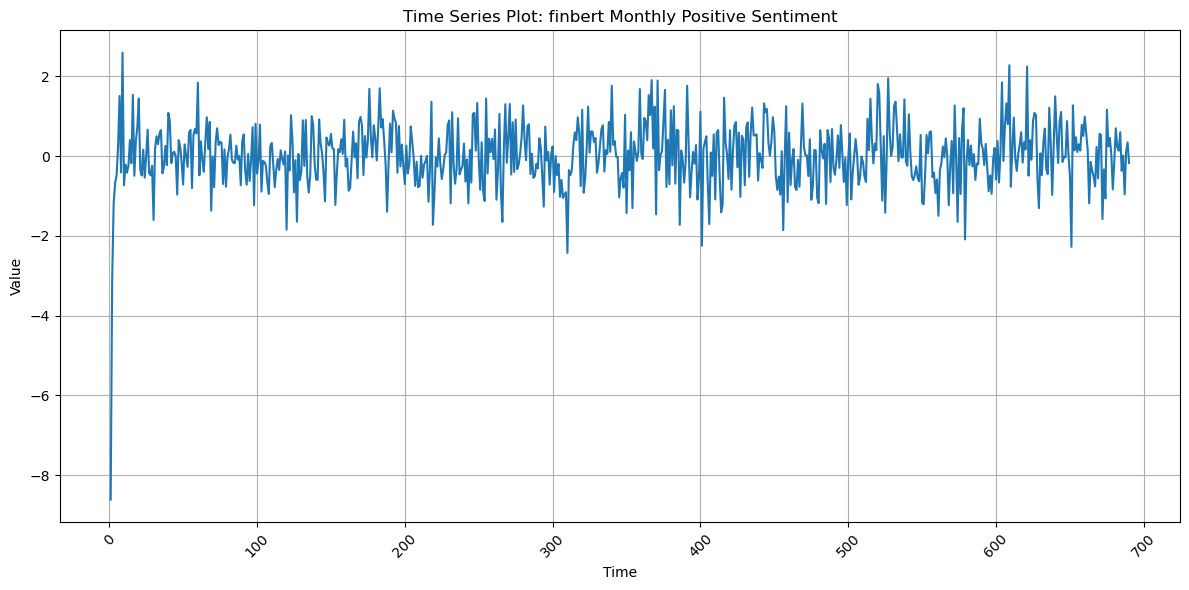

Augmented Dickey-Fuller Test Results for finbert Monthly Negative Sentiment:
ADF Statistic: -2.7795
p-value: 0.0613
Critical values:
	1%: -3.4401
	5%: -2.8659
	10%: -2.5691




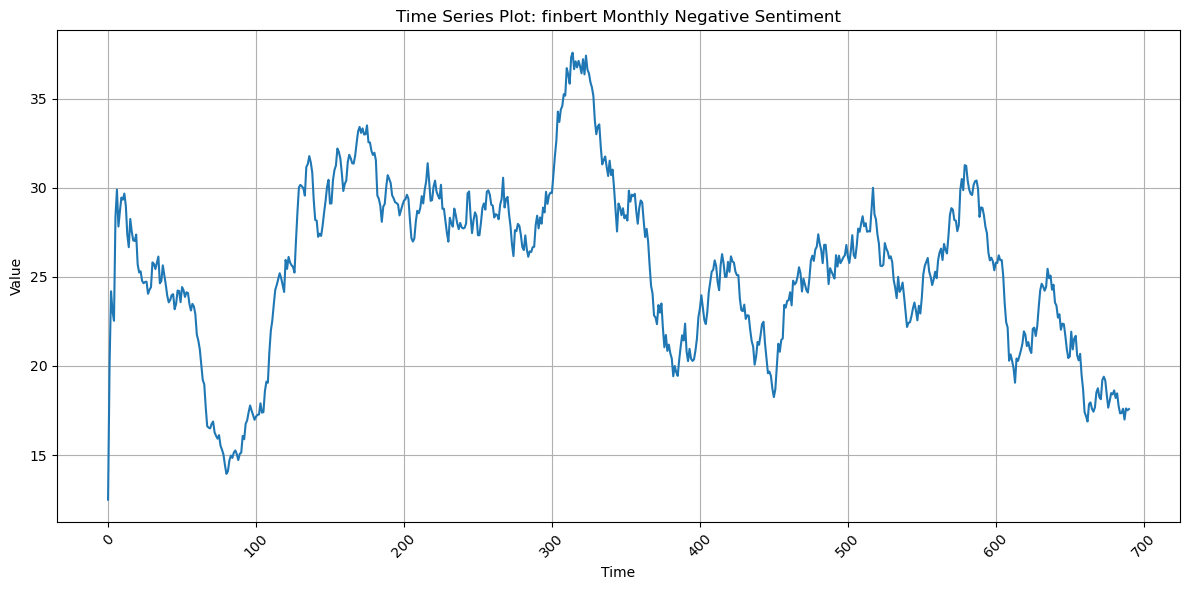

Augmented Dickey-Fuller Test Results for finbert Monthly Returns:
ADF Statistic: -3.5461
p-value: 0.0069
Critical values:
	1%: -3.4399
	5%: -2.8658
	10%: -2.5690




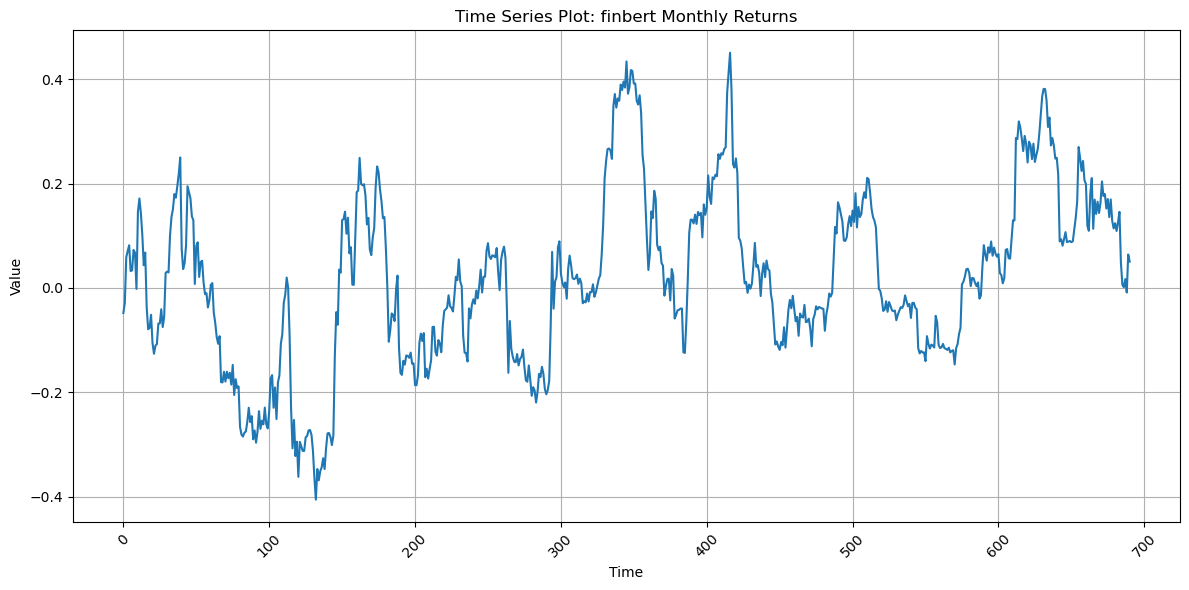

Augmented Dickey-Fuller Test Results for finbert Monthly Returns:
ADF Statistic: -2.4385
p-value: 0.1312
Critical values:
	1%: -3.4401
	5%: -2.8658
	10%: -2.5691




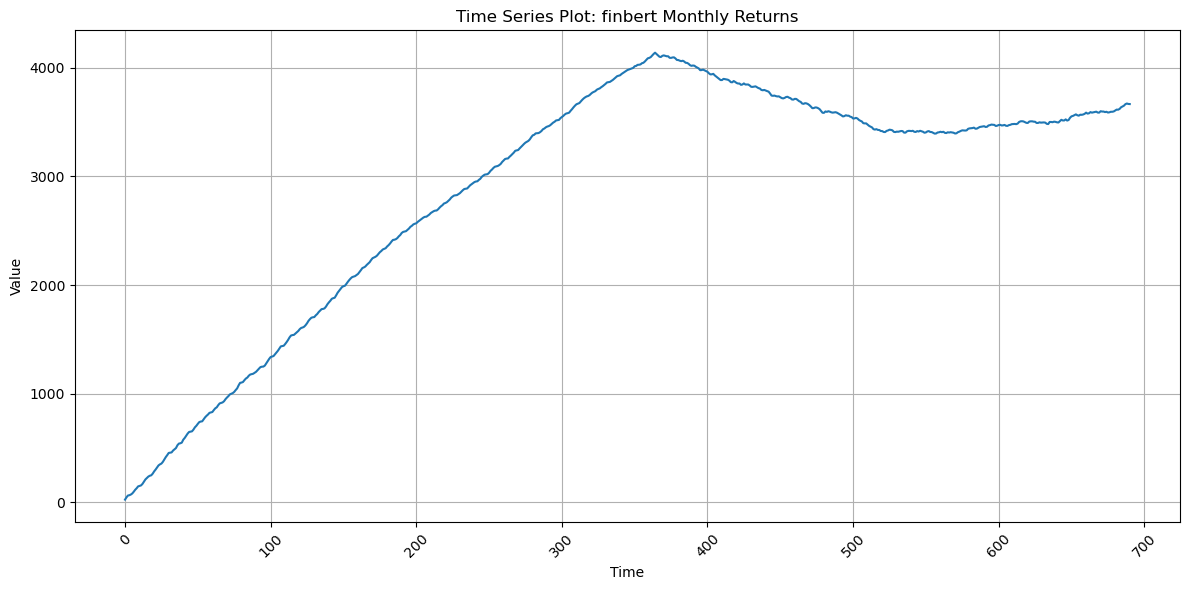

In [173]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, title):
    """
    Perform Augmented Dickey-Fuller test and create visualization for a time series.
    
    Args:
        series: Time series data
        title: Title for the plot
    """
    # Perform Augmented Dickey-Fuller test
    result = adfuller(series.dropna())
    
    print(f'Augmented Dickey-Fuller Test Results for {title}:')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    print('\n')
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    plt.plot(series.index, series.values)
    plt.title(f'Time Series Plot: {title}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# For each model in merged_dfs
for model_name, df in merged_dfs.items():
    print(f"\nAnalyzing {model_name.upper()} model:")
    
    # Check stationarity for monthly sentiment (positive)
    check_stationarity(df['rolling_monthly_diff'], f'{model_name} Monthly Positive Sentiment')
    
    # Check stationarity for monthly sentiment (negative)
    check_stationarity(df['rolling_monthly_neg'], f'{model_name} Monthly Negative Sentiment')
    
    # Check stationarity for returns
    check_stationarity(df['Return_M1'], f'{model_name} Monthly Returns')
    
    # Check stationarity for rolling yearly article counts
    check_stationarity(df['count_yearly_total'], f'{model_name} Monthly Returns')


## Correlation Analysis

In [174]:
def plot_correlation_matrix(merged_df, figsize=(20, 16), title="Triangular Correlation Matrix"):
    """
    Create and plot a correlation matrix for sentiment, returns, and technical indicators.
    
    Args:
        merged_df (pd.DataFrame): Merged dataframe containing sentiment and price data
        figsize (tuple): Figure size for the plot (default: (20, 16))
        title (str): Title for the correlation matrix plot (default: "Triangular Correlation Matrix")
    """
    # Define variables for correlation matrix
    variables = [
        #"rolling_monthly",      # Positive Sentiment
        #"rolling_monthly_neg",  # Negative Sentiment
        "Return_M1", # (Future returns "Return_D1", "Return_W1", "Return_Q1", "Return_Y1")
        #"Return_M1_H",  # Historical returns
        #"EMA","RSI", "MACD_signal" # Technical Indicators "RSI", "MACD_signal",
        #"prev_month_change", "count_yearly_total", "count_quarterly_total", "count_monthly_total", "count_weekly_total" #article counts
        #"rolling_monthly_squared", "rolling_monthly_neg_squared", "prev_month_change_squared", #squared terms
        #"rolling_monthly_prev_month_change", "rolling_monthly_neg_prev_month_change","count_weekly_rolling_monthly", "count_monthly_rolling_monthly", "count_quarterly_rolling_monthly", "count_yearly_rolling_monthly","count_weekly_rolling_monthly_neg", "count_monthly_rolling_monthly_neg", "count_quarterly_rolling_monthly_neg", "count_yearly_rolling_monthly_neg" #interaction terms
        ]
    
    variables = ["Return_M1","rolling_monthly","rolling_monthly_neg"]
    
    # Calculate the correlation matrix
    correlation_matrix = merged_df[variables].corr()
    
    # Plot the heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(title)
    plt.show()
    
    return correlation_matrix

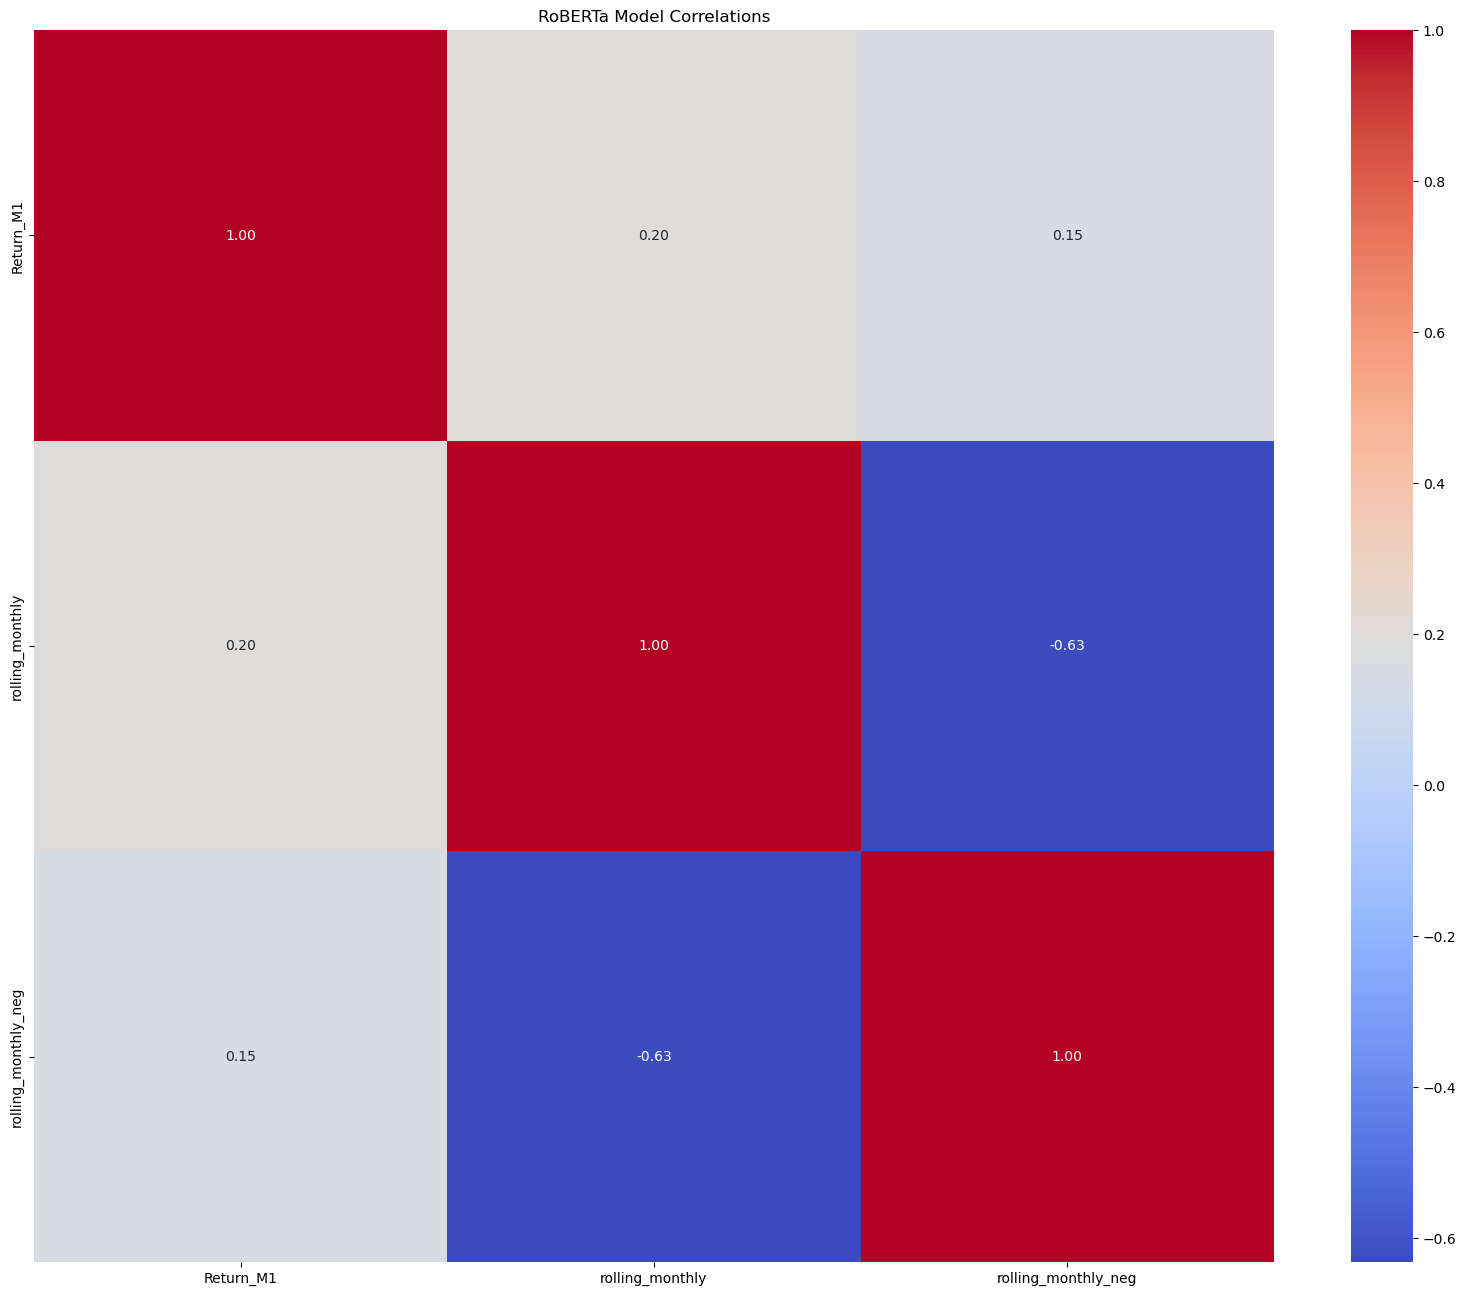

,Return_M1,rolling_monthly,rolling_monthly_neg
Return_M1,1.000000,0.195347,0.152428
rolling_monthly,0.195347,1.000000,-0.631726
rolling_monthly_neg,0.152428,-0.631726,1.000000


In [175]:
# For RoBERTa
plot_correlation_matrix(merged_dfs['roberta'], title="RoBERTa Model Correlations")

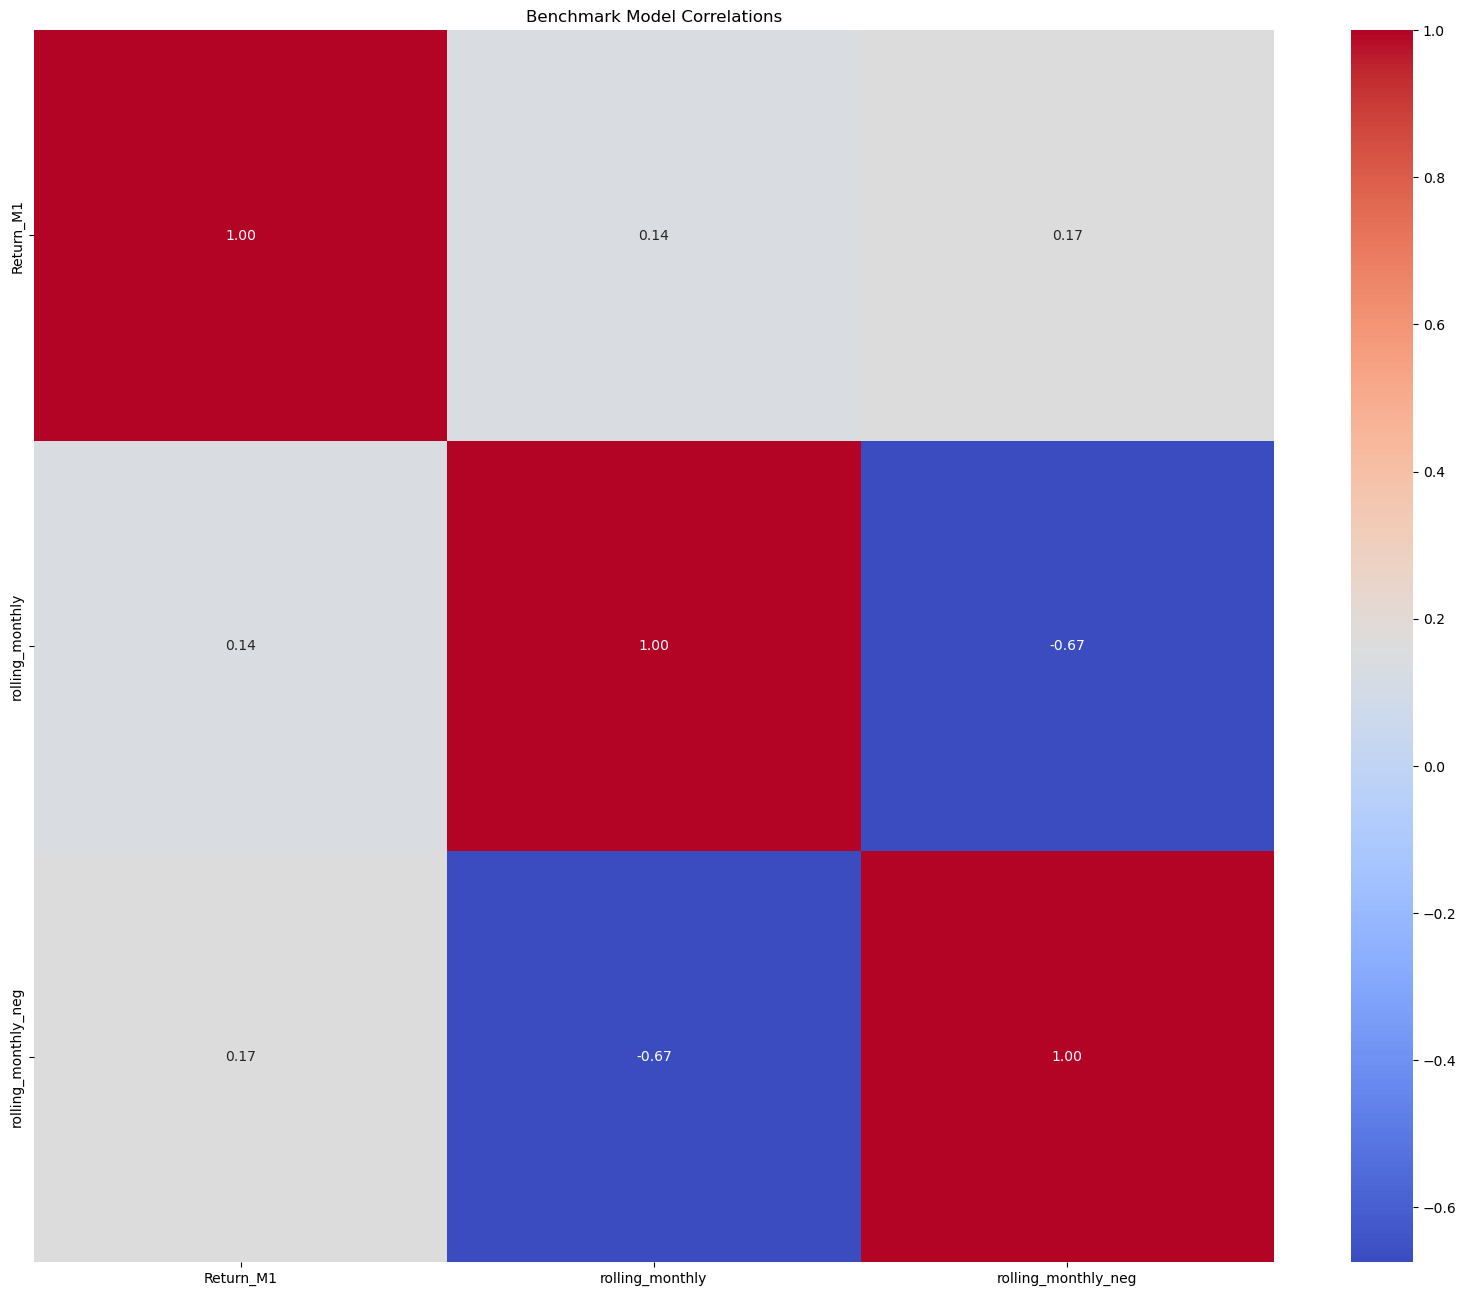

,Return_M1,rolling_monthly,rolling_monthly_neg
Return_M1,1.000000,0.138499,0.166093
rolling_monthly,0.138499,1.000000,-0.674526
rolling_monthly_neg,0.166093,-0.674526,1.000000


In [176]:
# For benchmark
plot_correlation_matrix(merged_dfs['benchmark'], title="Benchmark Model Correlations")

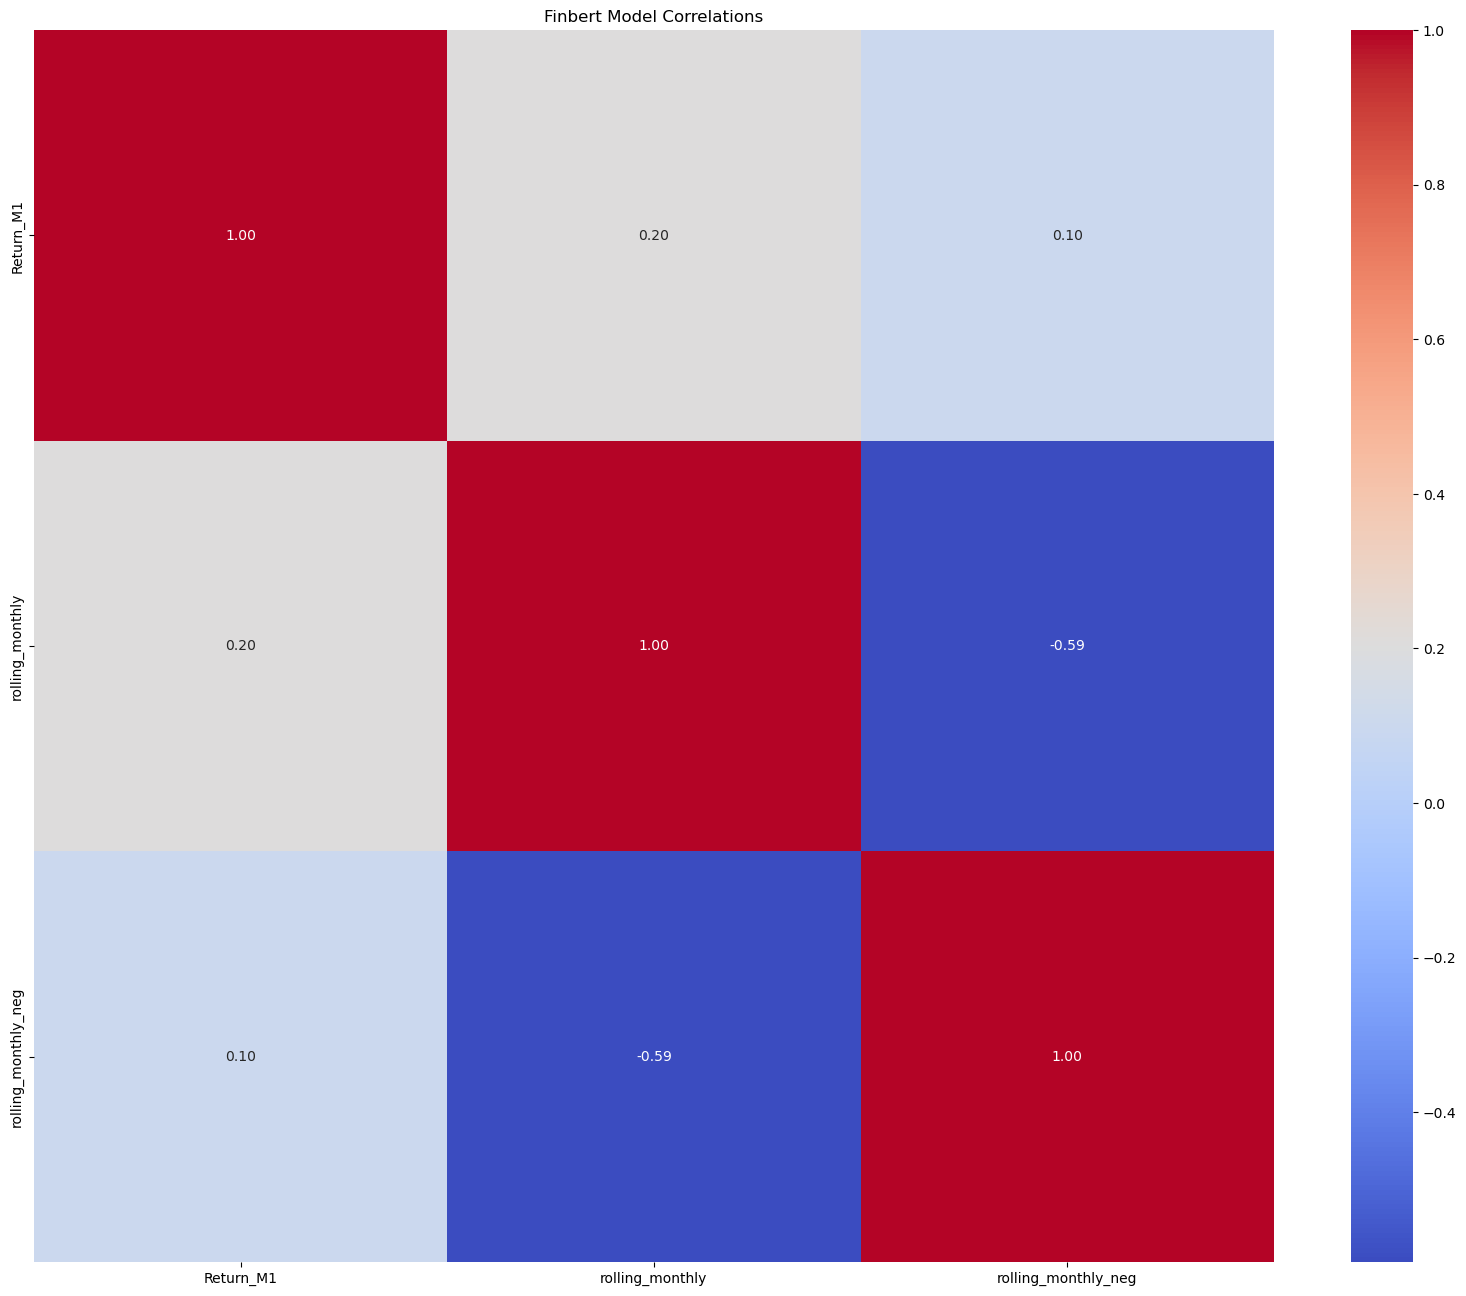

,Return_M1,rolling_monthly,rolling_monthly_neg
Return_M1,1.000000,0.203610,0.099341
rolling_monthly,0.203610,1.000000,-0.594167
rolling_monthly_neg,0.099341,-0.594167,1.000000


In [177]:
# For Finbert
plot_correlation_matrix(merged_dfs['finbert'], title="Finbert Model Correlations")

## Model Training & Analysis

### Standard Linear Regression

In [178]:
def run_time_series_regression(df, feature_columns, target_column='Return_M1', n_splits=5, 
                             test_size_pct=0.2, show_plots=True, show_summaries=True,
                             standardize=False):
    """
    Run time series regression with cross-validation.
    
    Args:
        df (pd.DataFrame): Input DataFrame
        feature_columns (list): List of feature column names
        target_column (str): Name of target column (default: 'Return_M1')
        n_splits (int): Number of splits for time series CV (default: 5)
        test_size_pct (float): Percentage of data for test set (default: 0.2)
        show_plots (bool): Whether to show visualization plots (default: True)
        show_summaries (bool): Whether to print regression summaries (default: True)
        standardize (bool): Whether to apply Z-score standardization (default: False)
    
    Returns:
        dict: Dictionary containing model performance metrics and predictions
    """
    # Prepare features and target
    X = sm.add_constant(df[feature_columns])
    y = df[target_column]
    
    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=int(len(X) * test_size_pct))
    
    # Initialize StandardScaler if standardization is requested
    scaler = StandardScaler() if standardize else None
    
    # Prepare lists to store results
    all_predictions = []
    all_actuals = []
    r2_scores = []
    fold_metrics = []
    directional_accuracies = []
    
    # Perform Time Series cross-validation
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        # Split the data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        if standardize:
            # Standardize features (excluding constant)
            X_train_std = X_train.copy()
            X_test_std = X_test.copy()
            X_train_std[feature_columns] = scaler.fit_transform(X_train[feature_columns])
            X_test_std[feature_columns] = scaler.transform(X_test[feature_columns])
            
            # Use standardized data
            X_train_final = X_train_std
            X_test_final = X_test_std
        else:
            # Use original data
            X_train_final = X_train
            X_test_final = X_test
        
        # Fit the model
        model = sm.OLS(y_train, X_train_final).fit()
        
        # Generate predictions
        predictions = model.predict(X_test_final)
        
        # Calculate directional predictions
        actual_up = y_test > 0
        pred_up = predictions > 0
        
        correct_up = np.sum((pred_up == True) & (actual_up == True))
        correct_down = np.sum((pred_up == False) & (actual_up == False))
        total_up = np.sum(actual_up)
        total_down = np.sum(~actual_up)
        
        up_accuracy = correct_up / total_up if total_up > 0 else 0
        down_accuracy = correct_down / total_down if total_down > 0 else 0
        
        # Calculate directional accuracy for this fold
        correct_direction = np.sum((predictions > 0) == (y_test > 0))
        directional_accuracy = correct_direction / len(predictions)
        directional_accuracies.append(directional_accuracy)
        
        # Store results
        all_predictions.extend(predictions)
        all_actuals.extend(y_test)
        r2_scores.append(model.rsquared)
        
        # Store fold metrics
        fold_metrics.append({
            'fold': fold + 1,
            'r2': model.rsquared,
            'train_size': len(X_train),
            'test_size': len(X_test),
            'directional_accuracy': directional_accuracy,
            'up_accuracy': up_accuracy,
            'down_accuracy': down_accuracy,
            'correct_up': correct_up,
            'correct_down': correct_down,
            'total_up': total_up,
            'total_down': total_down
        })
        
        # Print regression summary if enabled
        if show_summaries:
            print(f"Fold {fold + 1} Regression Summary:")
            print(model.summary())
            print(f"Directional Accuracy: {directional_accuracy:.4f}")
            print("\n")
    
    # Convert to numpy arrays for easier calculation
    all_predictions = np.array(all_predictions)
    all_actuals = np.array(all_actuals)
    
    # Calculate overall metrics
    actual_up = all_actuals > 0
    pred_up = all_predictions > 0
    
    total_up_predictions = np.sum(pred_up)
    total_down_predictions = np.sum(~pred_up)
    correct_up = np.sum((pred_up == True) & (actual_up == True))
    correct_down = np.sum((pred_up == False) & (actual_up == False))
    total_actual_up = np.sum(actual_up)
    total_actual_down = np.sum(~actual_up)
    
    # Calculate errors for positive and negative returns
    errors_on_positive = np.abs(all_predictions[actual_up] - all_actuals[actual_up])
    errors_on_negative = np.abs(all_predictions[~actual_up] - all_actuals[~actual_up])
    
    # Calculate average errors
    avg_error_positive = np.mean(errors_on_positive) if len(errors_on_positive) > 0 else 0
    avg_error_negative = np.mean(errors_on_negative) if len(errors_on_negative) > 0 else 0
    
    # Calculate metrics
    average_r2 = sum(r2_scores) / len(r2_scores)
    average_directional_accuracy = sum(directional_accuracies) / len(directional_accuracies)
    mse = mean_squared_error(all_actuals, all_predictions)
    mae = mean_absolute_error(all_actuals, all_predictions)
    rmse = mse ** 0.5
    
    # Calculate overall directional accuracy
    overall_correct_direction = np.sum((np.array(all_predictions) > 0) == (np.array(all_actuals) > 0))
    
    # Create visualization if enabled
    if show_plots:
        plt.figure(figsize=(10, 6))
        plt.scatter(all_actuals, all_predictions, alpha=0.5)
        plt.plot([min(all_actuals), max(all_actuals)], 
                [min(all_actuals), max(all_actuals)], 'r--', lw=2)
        plt.xlabel('Actual Returns')
        plt.ylabel('Predicted Returns')
        title = 'Actual vs Predicted Returns\nTime Series Cross-Validation'
        if standardize:
            title += '\nWith Z-score standardization'
        plt.title(title)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    
    # Print metrics
    print(f"\nAverage R^2 across all folds: {average_r2:.4f}")
    print(f"Average Directional Accuracy across folds: {average_directional_accuracy:.4f}")
    print(f"Mean Squared Error: {mse:.6f}")
    print(f"Mean Absolute Error: {mae:.6f}")
    print(f"Root Mean Squared Error: {rmse:.6f}")
    
    # Print enhanced metrics
    print("\nDirectional Prediction Analysis:")
    print(f"Up Movement Predictions: {total_up_predictions} ({total_up_predictions/len(all_predictions)*100:.1f}%)")
    print(f"Down Movement Predictions: {total_down_predictions} ({total_down_predictions/len(all_predictions)*100:.1f}%)")
    print(f"\nCorrect Up Predictions: {correct_up}/{total_actual_up} ({correct_up/total_actual_up*100:.1f}% accuracy)")
    print(f"Correct Down Predictions: {correct_down}/{total_actual_down} ({correct_down/total_actual_down*100:.1f}% accuracy)")
    print(f"\nAverage Error on Positive Returns: {avg_error_positive:.6f}")
    print(f"Average Error on Negative Returns: {avg_error_negative:.6f}")
    
    # Return results
    return {
        'average_r2': average_r2,
        'average_directional_accuracy': average_directional_accuracy,
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'r2_scores': r2_scores,
        'directional_accuracies': directional_accuracies,
        'fold_metrics': fold_metrics,
        'predictions': all_predictions,
        'actuals': all_actuals,
        'up_down_metrics': {
            'total_up_predictions': total_up_predictions,
            'total_down_predictions': total_down_predictions,
            'correct_up': correct_up,
            'correct_down': correct_down,
            'total_actual_up': total_actual_up,
            'total_actual_down': total_actual_down,
            'up_accuracy': correct_up/total_actual_up if total_actual_up > 0 else 0,
            'down_accuracy': correct_down/total_actual_down if total_actual_down > 0 else 0,
            'avg_error_positive': avg_error_positive,
            'avg_error_negative': avg_error_negative
        }
    }

### No sentiment (benchmark)

In [195]:
features = features = ["EMA","count_yearly_total", "prev_month_change"]
results = run_time_series_regression(
    df=merged_dfs['roberta'],
    feature_columns=features,
    target_column='Return_M1',
    n_splits=3 ,
    test_size_pct=0.2,
    show_plots=False,
    show_summaries=True,
    standardize=True
)

Fold 1 Regression Summary:
                            OLS Regression Results                            
Dep. Variable:              Return_M1   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     52.65
Date:                Sun, 19 Jan 2025   Prob (F-statistic):           6.96e-27
Time:                        20:29:01   Log-Likelihood:                 195.55
No. Observations:                 277   AIC:                            -383.1
Df Residuals:                     273   BIC:                            -368.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const    

### Sentiment Only

Roberta

In [196]:
features = ['rolling_monthly', "rolling_monthly_neg", "rolling_monthly_squared", "rolling_monthly_neg_squared"]
results = run_time_series_regression(
    df=merged_dfs['roberta'],
    feature_columns=features,
    target_column='Return_M1',
    n_splits=3 ,
    test_size_pct=0.2,
    show_plots=False,
    show_summaries=True,
    standardize=True
)

Fold 1 Regression Summary:
                            OLS Regression Results                            
Dep. Variable:              Return_M1   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     21.98
Date:                Sun, 19 Jan 2025   Prob (F-statistic):           9.74e-16
Time:                        20:50:29   Log-Likelihood:                 171.12
No. Observations:                 277   AIC:                            -332.2
Df Residuals:                     272   BIC:                            -314.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

Benchmark

In [197]:
features = ['rolling_monthly', "rolling_monthly_neg", "rolling_monthly_squared", "rolling_monthly_neg_squared"]
results = run_time_series_regression(
    df=merged_dfs['benchmark'],
    feature_columns=features,
    target_column='Return_M1',
    n_splits=3 ,
    test_size_pct=0.2,
    show_plots=False,
    show_summaries=True,
    standardize=True
)

Fold 1 Regression Summary:
                            OLS Regression Results                            
Dep. Variable:              Return_M1   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     14.64
Date:                Sun, 19 Jan 2025   Prob (F-statistic):           7.69e-11
Time:                        20:51:58   Log-Likelihood:                 159.32
No. Observations:                 277   AIC:                            -308.6
Df Residuals:                     272   BIC:                            -290.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

Finbert

In [205]:
features = ['rolling_monthly', "rolling_monthly_neg", "rolling_monthly_squared", "rolling_monthly_neg_squared"]
results = run_time_series_regression(
    df=merged_dfs['finbert'],
    feature_columns=features,
    target_column='Return_M1',
    n_splits=3 ,
    test_size_pct=0.2,
    show_plots=False,
    show_summaries=True,
    standardize=True
)

Fold 1 Regression Summary:
                            OLS Regression Results                            
Dep. Variable:              Return_M1   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     19.03
Date:                Sun, 19 Jan 2025   Prob (F-statistic):           8.26e-14
Time:                        21:57:43   Log-Likelihood:                 166.48
No. Observations:                 277   AIC:                            -323.0
Df Residuals:                     272   BIC:                            -304.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

#### Complete model with article counts and technical indicators

Roberta

In [209]:
#features = ['rolling_monthly', "rolling_monthly_neg", "rolling_monthly_squared", "rolling_monthly_neg_squared", "EMA","count_yearly_total", "count_yearly_rolling_monthly", "count_yearly_rolling_monthly_neg", "prev_month_change"]
features = ["rolling_monthly_diff", "rolling_monthly_neg", "rolling_monthly_neg_squared", "EMA", "prev_month_change"]
results = run_time_series_regression(
    df=merged_dfs['roberta'],
    feature_columns=features,
    target_column='Return_M1',
    n_splits=3 ,
    test_size_pct=0.2,
    show_plots=False,
    show_summaries=True,
    standardize=True
)

Fold 1 Regression Summary:
                            OLS Regression Results                            
Dep. Variable:              Return_M1   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     7.999
Date:                Sun, 19 Jan 2025   Prob (F-statistic):           4.75e-07
Time:                        22:00:16   Log-Likelihood:                 150.41
No. Observations:                 276   AIC:                            -288.8
Df Residuals:                     270   BIC:                            -267.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

Benchmark

In [201]:
features = ['rolling_monthly', "rolling_monthly_neg", "rolling_monthly_squared", "rolling_monthly_neg_squared", "EMA","count_yearly_total", "count_yearly_rolling_monthly", "count_yearly_rolling_monthly_neg", "prev_month_change"]
results = run_time_series_regression(
    df=merged_dfs['benchmark'],
    feature_columns=features,
    target_column='Return_M1',
    n_splits=3 ,
    test_size_pct=0.2,
    show_plots=False,
    show_summaries=True,
    standardize=True
)

Fold 1 Regression Summary:
                            OLS Regression Results                            
Dep. Variable:              Return_M1   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     26.99
Date:                Sun, 19 Jan 2025   Prob (F-statistic):           5.89e-33
Time:                        21:06:35   Log-Likelihood:                 221.93
No. Observations:                 277   AIC:                            -423.9
Df Residuals:                     267   BIC:                            -387.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

Finbert

In [202]:

features = ['rolling_monthly', "rolling_monthly_neg", "rolling_monthly_squared", "rolling_monthly_neg_squared", "EMA","count_yearly_total", "count_yearly_rolling_monthly", "count_yearly_rolling_monthly_neg", "prev_month_change"]
results = run_time_series_regression(
    df=merged_dfs['finbert'],
    feature_columns=features,
    target_column='Return_M1',
    n_splits=3 ,
    test_size_pct=0.2,
    show_plots=False,
    show_summaries=True,
    standardize=True
)

Fold 1 Regression Summary:
                            OLS Regression Results                            
Dep. Variable:              Return_M1   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     32.95
Date:                Sun, 19 Jan 2025   Prob (F-statistic):           1.32e-38
Time:                        21:07:27   Log-Likelihood:                 235.78
No. Observations:                 277   AIC:                            -451.6
Df Residuals:                     267   BIC:                            -415.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

### Lasso/Ridge Linear Regression

#### Lasso

In [211]:
def run_lasso_regression(df, feature_columns, target_column='Return_M1', alpha=1.0, standardize=True):
    """
    Run Lasso regression without train-test split.
    
    Args:
        df (pd.DataFrame): Input DataFrame
        feature_columns (list): List of feature column names
        target_column (str): Name of target column (default: 'Return_M1')
        alpha (float): Regularization strength (default: 1.0)
        standardize (bool): Whether to apply Z-score standardization (default: True)
    
    Returns:
        dict: Dictionary containing model performance metrics and coefficients
    """
    
    # Prepare features and target
    X = df[feature_columns]
    y = df[target_column]
    
    # Standardize if requested
    if standardize:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    
    # Add constant
    X = sm.add_constant(X)
    
    # Fit Lasso regression
    model = Lasso(alpha=alpha)
    model.fit(X, y)
    
    # Generate predictions
    predictions = model.predict(X)
    
    # Calculate metrics
    r2 = r2_score(y, predictions)
    mse = mean_squared_error(y, predictions)
    mae = mean_absolute_error(y, predictions)
    rmse = mse ** 0.5
    
    # Print coefficients
    print("Model Coefficients:")
    print(f"Intercept: {model.intercept_:.6f}")
    for feat, coef in zip(feature_columns, model.coef_[1:]):  # Skip first coefficient as it's for constant
        print(f"{feat}: {coef:.6f}")
    
    # Print metrics
    print(f"\nModel Performance:")
    print(f"R^2 Score: {r2:.4f}")
    print(f"Mean Squared Error: {mse:.6f}")
    print(f"Mean Absolute Error: {mae:.6f}")
    print(f"Root Mean Squared Error: {rmse:.6f}")
    
    return {
        'r2': r2,
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'coefficients': dict(zip(['intercept'] + feature_columns, 
                               [model.intercept_] + list(model.coef_[1:]))),
        'predictions': predictions
    }
    
# Running regression
results = run_lasso_regression(
    df=merged_dfs['roberta'],
    feature_columns=['rolling_monthly', 'rolling_monthly_neg',"prev_month_change", "RSI", "MACD_signal", "EMA", "Return_D1_H", "Return_W1_H","rolling_monthly_squared", "rolling_monthly_neg_squared", "prev_month_change_squared",'rolling_monthly_prev_month_change','rolling_monthly_neg_prev_month_change', "rolling_monthly_diff"],
    alpha=0.01,  # adjust regularization strength as needed
    standardize=True
)

Model Coefficients:
Intercept: 0.016816
rolling_monthly: 0.042039
rolling_monthly_neg: 0.027451
prev_month_change: 0.000000
RSI: 0.000000
MACD_signal: 0.000000
EMA: -0.024648
Return_D1_H: 0.000000
Return_W1_H: 0.000000
rolling_monthly_squared: 0.000000
rolling_monthly_neg_squared: 0.000000
prev_month_change_squared: 0.011340
rolling_monthly_prev_month_change: 0.000000
rolling_monthly_neg_prev_month_change: 0.000000
rolling_monthly_diff: 0.000000

Model Performance:
R^2 Score: 0.1596
Mean Squared Error: 0.022220
Mean Absolute Error: 0.122651
Root Mean Squared Error: 0.149064


#### Ridge

In [141]:
def run_ridge_regression(df, feature_columns, target_column='Return_M1', alpha=1.0, standardize=True):
    """
    Run Ridge regression without train-test split.
    
    Args:
        df (pd.DataFrame): Input DataFrame
        feature_columns (list): List of feature column names
        target_column (str): Name of target column (default: 'Return_M1')
        alpha (float): Regularization strength (default: 1.0)
        standardize (bool): Whether to apply Z-score standardization (default: True)
    
    Returns:
        dict: Dictionary containing model performance metrics and coefficients
    """
    
    # Prepare features and target
    X = df[feature_columns]
    y = df[target_column]
    
    # Standardize if requested
    if standardize:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    
    # Add constant
    X = sm.add_constant(X)
    
    # Fit Ridge regression
    model = Ridge(alpha=alpha)
    model.fit(X, y)
    
    # Generate predictions
    predictions = model.predict(X)
    
    # Calculate metrics
    r2 = r2_score(y, predictions)
    mse = mean_squared_error(y, predictions)
    mae = mean_absolute_error(y, predictions)
    rmse = mse ** 0.5
    
    # Print coefficients
    print("Model Coefficients:")
    print(f"Intercept: {model.intercept_:.6f}")
    for feat, coef in zip(feature_columns, model.coef_[1:]):  # Skip first coefficient as it's for constant
        print(f"{feat}: {coef:.6f}")
    
    # Print metrics
    print(f"\nModel Performance:")
    print(f"R^2 Score: {r2:.4f}")
    print(f"Mean Squared Error: {mse:.6f}")
    print(f"Mean Absolute Error: {mae:.6f}")
    print(f"Root Mean Squared Error: {rmse:.6f}")
    
    return {
        'r2': r2,
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'coefficients': dict(zip(['intercept'] + feature_columns, 
                               [model.intercept_] + list(model.coef_[1:]))),
        'predictions': predictions
    }
    
    # Usage
results = run_ridge_regression(
    df=merged_dfs['roberta'],
    feature_columns=['rolling_monthly', "rolling_monthly_neg", "rolling_monthly_squared", "rolling_monthly_neg_squared", "EMA","count_yearly_total", "count_yearly_rolling_monthly", "count_yearly_rolling_monthly_neg", "prev_month_change"],
    alpha=0.1,  # adjust regularization strength as needed
    standardize=True
)

Model Coefficients:
Intercept: 0.008071
rolling_monthly: -0.013407
rolling_monthly_neg: 0.119592
rolling_monthly_squared: -0.003170
rolling_monthly_neg_squared: -0.148876
EMA: -0.027801
count_yearly_total: -0.341896
count_yearly_rolling_monthly: 0.219731
count_yearly_rolling_monthly_neg: 0.227212
prev_month_change: 0.031552

Model Performance:
R^2 Score: 0.2599
Mean Squared Error: 0.019653
Mean Absolute Error: 0.115320
Root Mean Squared Error: 0.140190
